In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import json
from collections import defaultdict
import os
from evaluate_flipflop import get_digit_accuracy, get_relaxed_distance_accuracy, get_strict_distance_accuracy, get_per_dist_accuracy

In [134]:
# Define a fixed color mapping for models
MODEL_COLORS = {
    "llama3.1_70B-instruct": "darkviolet",
    "llama3.3_70B-instruct": "orange",
    "llama3.1_8B-instruct": "green",
    "OLMo_7B-instruct": "red",
    "OLMo2_7B-instruct": "skyblue",
    "OLMo2_13B-instruct": "brown",
    "OLMo_7B": "lightcoral",
    "OLMo2_13B": "peru",
    "llama3.1_70B": "mediumorchid",
    "llama3.1_8B": "lightgreen",
    "OLMo2_7B": "lightcyan"
}

In [135]:
def get_data(path):
    with open(path, 'r') as file:
        data = [json.loads(line) for line in file]
    return data

def get_base_accuracy(responses):
    """
    Calculates the baseline (raw) accuracy of the reported answers
    :param responses: list of dictionaries containing model's answers
    :return: float, correct answers proportion
    """

    correct = 0
    for response in responses:
        try:
            if int(response['answer']) == int(response['last_valid_token']):
                correct += 1
        except Exception as e:
            #print(f'Invalid response given {response['answer']}')
            continue

    return correct / len(responses)

In [136]:
def get_of_length(length, path):
    data = get_data(path)

    flipflop_of_length = []
    for line in data:
        if len(line['flipflop']) == length:
            flipflop_of_length.append(line)

    return flipflop_of_length

In [137]:
# could have just taken lengths and positions from the file name but oh well
def count_custom_length(input_string):
    # Define keywords and their lengths
    keywords = ["write", "read", "ignore"]
    keyword_length = 1

    i = 0
    total_length = 0

    while i < len(input_string):
        # Check if the substring matches any of the keywords
        matched = False
        for keyword in keywords:
            if input_string[i:i+len(keyword)] == keyword:
                total_length += keyword_length
                i += len(keyword)
                matched = True
                break

        # If no keyword matches, check if it's a digit
        if not matched:
            if input_string[i].isdigit():
                total_length += 1
                i += 1
            else:
                raise ValidationError

    return total_length

In [138]:
def find_last_write_idx(input_string):
    pattern = r'(write|read|ignore)([01])'
    
    matches = re.findall(pattern, input_string)
    
    result = []
    for action, number in matches:
        result.append(action)
        result.append(number)

    for i in range(len(result)-1, -1, -1):
        if result[i] == "write":
            return i

In [139]:
def plot_distance_accuracy(models, title, output_path, model_colors=None, fig_width=26, fig_height=7, bar_width=0.2, x_axis_text="Group (Flipflop Length, Last Write Index)"):
    """
    Creates a grouped histogram plot of average base accuracy by flipflop length across models.

    Args:
        models (dict): Dictionary where keys are model names and values are lists of folder paths.
        output_path (str): Path to save the generated plot.

    Returns:
        None
    """
    model_results = {}
    
    for model_name, folders in models.items():
        all_samples = []

        for folder_path in folders:
            for file_name in os.listdir(folder_path):
                if file_name.endswith(".jsonl"):
                    file_path = os.path.join(folder_path, file_name)
                    try:
                        with open(file_path, 'r', encoding='utf-8') as file:
                            one_sample_data = [json.loads(line) for line in file if line.strip()]
                            
                            if not one_sample_data:  # Check for empty data
                                print(f"Warning: {file_path} is empty or has no valid data")
        
                            all_samples.append(one_sample_data)
        
                    except json.JSONDecodeError:
                        print(f"Error: Failed to decode JSON in {file_path}")
    
        print(f"{model_name}: Loaded {len(all_samples)} entries from all folders.")
    
        grouped_accuracies = defaultdict(list)
    
        for result in all_samples:
            acc = get_base_accuracy(result)
            length = len(result[0]['flipflop'])
            idx = result[0]['last_write_index']
            grouped_accuracies[(length, idx)].append(acc)
    
        grouped_results = {}
        for (length, idx), accuracies in grouped_accuracies.items():
            avg_acc = sum(accuracies) / len(accuracies)
            grouped_results[(length, idx)] = avg_acc
    
        length_indices = defaultdict(set)
        for (length, idx) in grouped_results.keys():
            length_indices[length].add(idx)
    
        filtered_results = {}
        for length, indices in length_indices.items():
            if len(indices) >= 2:  
                first_idx = min(indices)
                last_idx = max(indices)
                filtered_results[(length, first_idx)] = grouped_results[(length, first_idx)]
                filtered_results[(length, last_idx)] = grouped_results[(length, last_idx)]
    
        model_results[model_name] = dict(sorted(filtered_results.items(), key=lambda x: (x[0][0], x[0][1])))
    
    plt.figure(figsize=(fig_width, fig_height))
    
    x_labels = []
    all_model_accuracies = []
    all_model_names = []
    all_groups = sorted({k for model in model_results.values() for k in model.keys()})
    
    for model_name, results in model_results.items():
        model_accuracies = [results.get(group, None) for group in all_groups]
        all_model_accuracies.append(model_accuracies)
        all_model_names.append(model_name)
    
    x_labels = [f"Len: {k[0]}, Idx: {k[1]}" for k in all_groups]
    x_positions = np.arange(len(x_labels))
    
    for i, (model_name, model_accuracies) in enumerate(zip(all_model_names, all_model_accuracies)):
        color = MODEL_COLORS.get(model_name, f"C{i}")  # Use predefined color, fallback to default matplotlib colors
        plt.bar(x_positions + i * bar_width, model_accuracies, width=bar_width, label=model_name, color=color, edgecolor="black")
    
    plt.axhline(y=0.5, color='red', linestyle='--', label="Baseline")  # Optional reference line
    
    plt.xlabel(x_axis_text)
    plt.ylabel("Average Base Accuracy")
    plt.title(title)
    plt.xticks(x_positions + (bar_width * (len(all_model_names) - 1) / 2), x_labels, rotation=45, ha="right")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()


In [140]:
def plot_per_model_distance_accuracy(models, title, output_path, base_color, fig_width=26, fig_height=7, bar_width=0.2, x_axis_text="Group (Flipflop Length, Last Write Index)"):
    """
    Creates a grouped histogram plot of average base accuracy by flipflop length across models.

    Args:
        models (dict): Dictionary where keys are model names and values are lists of folder paths.
        base_color (str): Base color for the bars.
        output_path (str): Path to save the generated plot.

    Returns:
        None
    """
    model_results = {}
    
    for model_name, folders in models.items():
        all_samples = []

        for folder_path in folders:
            for file_name in os.listdir(folder_path):
                if file_name.endswith(".jsonl"):
                    file_path = os.path.join(folder_path, file_name)
                    try:
                        with open(file_path, 'r', encoding='utf-8') as file:
                            one_sample_data = [json.loads(line) for line in file if line.strip()]
                            
                            if not one_sample_data:
                                print(f"Warning: {file_path} is empty or has no valid data")
    
                            all_samples.append(one_sample_data)
    
                    except json.JSONDecodeError:
                        print(f"Error: Failed to decode JSON in {file_path}")
    
        print(f"{model_name}: Loaded {len(all_samples)} entries from all folders.")
    
        grouped_accuracies = defaultdict(list)
    
        for result in all_samples:
            acc = get_base_accuracy(result)
            length = len(result[0]['flipflop'])
            idx = result[0]['last_write_index']
            grouped_accuracies[(length, idx)].append(acc)
    
        grouped_results = {key: sum(accs) / len(accs) for key, accs in grouped_accuracies.items()}
    
        length_indices = defaultdict(set)
        for (length, idx) in grouped_results.keys():
            length_indices[length].add(idx)
    
        filtered_results = {}
        for length, indices in length_indices.items():
            if len(indices) >= 2:  
                first_idx = min(indices)
                last_idx = max(indices)
                filtered_results[(length, first_idx)] = grouped_results[(length, first_idx)]
                filtered_results[(length, last_idx)] = grouped_results[(length, last_idx)]
    
        model_results[model_name] = dict(sorted(filtered_results.items(), key=lambda x: (x[0][0], x[0][1])))
    
    plt.figure(figsize=(fig_width, fig_height))
    
    x_labels = [f"Len: {k[0]}, Idx: {k[1]}" for k in sorted({k for model in model_results.values() for k in model.keys()})]
    x_positions = np.arange(len(x_labels))
    
    hatch_patterns = ['////']  # Define hatch patterns
    
    for i, (model_name, results) in enumerate(model_results.items()):
        model_accuracies = [results.get(group, None) for group in sorted(results.keys())]
        bars = plt.bar(x_positions + i * bar_width, model_accuracies, width=bar_width, label=model_name, color=base_color, edgecolor='black')
        
        # Apply hatching for every second model
        if i % 2 == 1:
            for bar in bars:
                bar.set_hatch(hatch_patterns[i % len(hatch_patterns)])
    
    plt.axhline(y=0.5, color='red', linestyle='--', label="Baseline")
    plt.xlabel(x_axis_text)
    plt.ylabel("Average Base Accuracy")
    plt.title(title)
    plt.xticks(x_positions + (bar_width * (len(model_results) - 1) / 2), x_labels, rotation=45, ha="right")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()


In [141]:
def plot_sparse_accuracy(models, title, output_path, model_colors=None, fig_width=26, fig_height=7, bar_width=0.15, x_axis_text='Flip-Flop Length'):
    """
    Creates a grouped histogram plot of average base accuracy by flipflop length across models.

    Args:
        models (dict): Dictionary where keys are model names and values are lists of folder paths.
        output_path (str): Path to save the generated plot.
        model_colors (dict, optional): Dictionary mapping model names to specific colors.

    Returns:
        None
    """
    results_by_model = {}
    for model_name, folders in models.items():
        all_samples = []
        for folder_path in folders:
            for file_name in os.listdir(folder_path):
                if file_name.endswith(".jsonl"):
                    file_path = os.path.join(folder_path, file_name)
                    with open(file_path, 'r', encoding='utf-8') as file:
                        one_sample_data = [json.loads(line) for line in file]
                        all_samples.append(one_sample_data)

        acc_by_length = defaultdict(list)
        for result in all_samples:
            acc = get_base_accuracy(result)
            length = count_custom_length(result[0]['flipflop']) if 'worded' in model_name else len(result[0]['flipflop'])
            acc_by_length[length].append(acc)

        average_acc_by_length = {length: sum(accs) / len(accs) for length, accs in acc_by_length.items()}
        results_by_model[model_name] = average_acc_by_length

    all_lengths = sorted(set(k for model_results in results_by_model.values() for k in model_results.keys()))
    selected_lengths = [length for length in all_lengths if length % 50 == 0]

    plot_data = {model: [results_by_model[model].get(length, 0) for length in selected_lengths] for model in models.keys()}

    x = np.arange(len(selected_lengths))
    width = bar_width

    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    for i, (model_name, accuracies) in enumerate(plot_data.items()):
        color = MODEL_COLORS.get(model_name, f"C{i}") 
        ax.bar(x + i * width, accuracies, width, label=model_name, color=color, edgecolor="black")

    ax.axhline(y=0.5, color='red', linestyle='--', linewidth=1.5, label='50% Baseline')

    ax.set_xlabel(x_axis_text)
    ax.set_ylabel('Average Base Accuracy')
    ax.set_title(title)
    ax.set_xticks(x + width / 2)
    ax.set_xticklabels(selected_lengths)
    ax.legend(fontsize=14)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()

In [142]:
def plot_per_model_sparse_accuracy(models, title, output_path, base_color, fig_width=26, fig_height=7, bar_width=0.15, x_axis_text='Flip-Flop Length'):
    """
    Creates a grouped histogram plot of average base accuracy by flipflop length across models.

    Args:
        models (dict): Dictionary where keys are model names and values are lists of folder paths.
        output_path (str): Path to save the generated plot.
        base_color (str): Base color for the bars.

    Returns:
        None
    """
    results_by_model = {}
    for model_name, folders in models.items():
        all_samples = []
        for folder_path in folders:
            for file_name in os.listdir(folder_path):
                if file_name.endswith(".jsonl"):
                    file_path = os.path.join(folder_path, file_name)
                    with open(file_path, 'r', encoding='utf-8') as file:
                        one_sample_data = [json.loads(line) for line in file]
                        all_samples.append(one_sample_data)

        acc_by_length = defaultdict(list)
        for result in all_samples:
            acc = get_base_accuracy(result)
            length = count_custom_length(result[0]['flipflop']) if 'worded' in model_name else len(result[0]['flipflop'])
            acc_by_length[length].append(acc)

        average_acc_by_length = {length: sum(accs) / len(accs) for length, accs in acc_by_length.items()}
        results_by_model[model_name] = average_acc_by_length

    all_lengths = sorted(set(k for model_results in results_by_model.values() for k in model_results.keys()))
    selected_lengths = [length for length in all_lengths if length % 50 == 0]

    plot_data = {model: [results_by_model[model].get(length, 0) for length in selected_lengths] for model in models.keys()}

    x = np.arange(len(selected_lengths))
    width = bar_width

    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    hatch_patterns = ['////', '\\\\']  # Define denser hatch patterns

    for i, (model_name, accuracies) in enumerate(plot_data.items()):
        bars = ax.bar(x + i * width, accuracies, width, label=model_name, color=base_color, edgecolor="black")

        # Apply white dense hatching for every second model
        if i % 2 == 1:
            for bar in bars:
                bar.set_hatch(hatch_patterns[i % len(hatch_patterns)])

    ax.axhline(y=0.5, color='red', linestyle='--', linewidth=1.5, label='50% Baseline')

    ax.set_xlabel(x_axis_text)
    ax.set_ylabel('Average Base Accuracy')
    ax.set_title(title)
    ax.set_xticks(x + width / 2)
    ax.set_xticklabels(selected_lengths)
    ax.legend(fontsize=14)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()


# SPARSE

# Llama 3.1 70B on all sparse subtasks

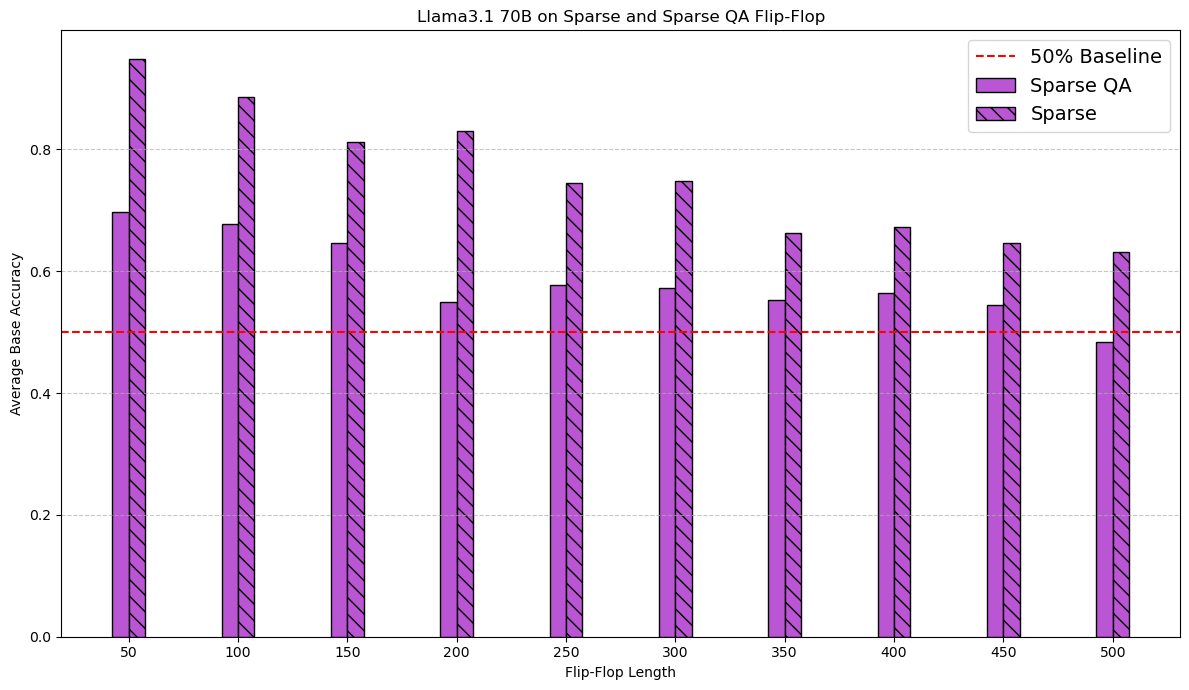

In [143]:
models = {
    "Sparse QA": ["llama3.1_70B/sparse-qa/s1", 
                          "llama3.1_70B/sparse-qa/s2", 
                          "llama3.1_70B/sparse-qa/s3", 
                          "llama3.1_70B/sparse-qa/s4", 
                          "llama3.1_70B/sparse-qa/s5"],
    "Sparse": ["llama3.1_70B/sparse/s1", 
                 "llama3.1_70B/sparse/s2", 
                 "llama3.1_70B/sparse/s3", 
                 "llama3.1_70B/sparse/s4", 
                 "llama3.1_70B/sparse/s5"]
}
title = "Llama3.1 70B on Sparse and Sparse QA Flip-Flop"
output_path = "graphs/llama3.1_70b_across_sparse_flipflop.png"
plot_per_model_sparse_accuracy(models, title, output_path, base_color="mediumorchid", fig_width=12)

# Llama 3.1-instruct 70B on all sparse subtasks

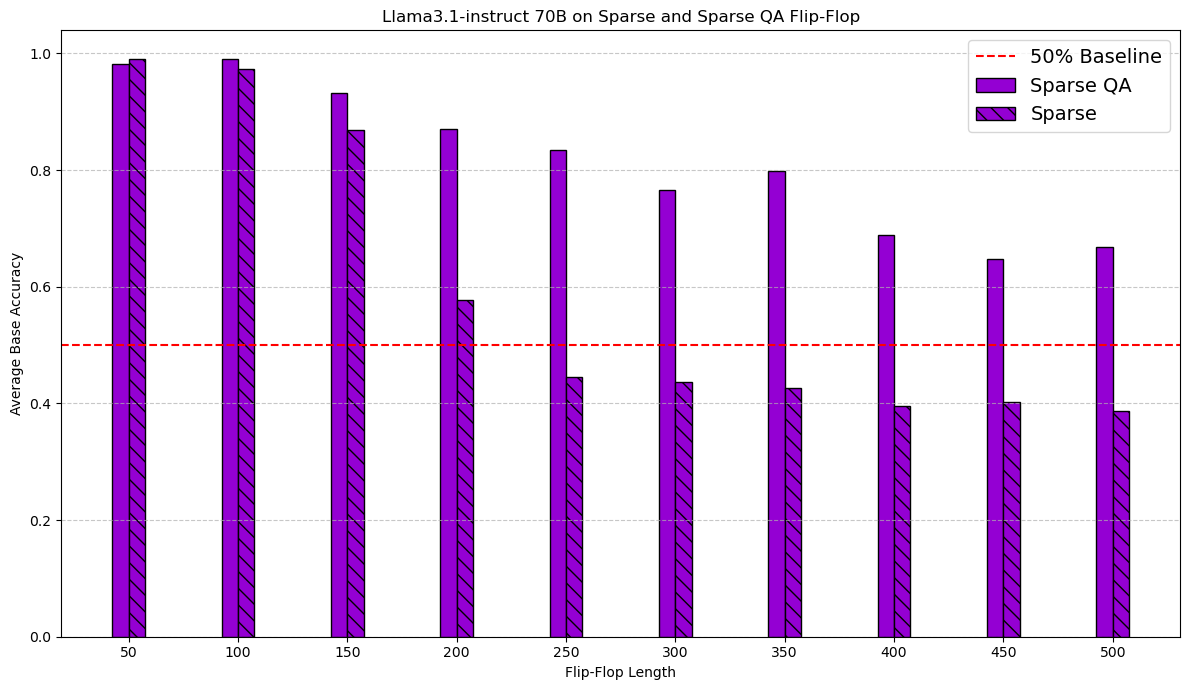

In [144]:
models = {
    "Sparse QA": ["llama3.1_70B-instruct/sparse-qa/s1", 
                          "llama3.1_70B-instruct/sparse-qa/s2", 
                          "llama3.1_70B-instruct/sparse-qa/s3", 
                          "llama3.1_70B-instruct/sparse-qa/s4", 
                          "llama3.1_70B-instruct/sparse-qa/s5"],
    "Sparse": ["llama3.1_70B-instruct/sparse/s1", 
                 "llama3.1_70B-instruct/sparse/s2", 
                 "llama3.1_70B-instruct/sparse/s3", 
                 "llama3.1_70B-instruct/sparse/s4", 
                 "llama3.1_70B-instruct/sparse/s5"]
}
title = "Llama3.1-instruct 70B on Sparse and Sparse QA Flip-Flop"
output_path = "graphs/llama3.1-instruct_70b_across_sparse_flipflop.png"
plot_per_model_sparse_accuracy(models, title, output_path, base_color="darkviolet", fig_width=12)

# Llama 3.3-instruct 70B on all sparse subtasks

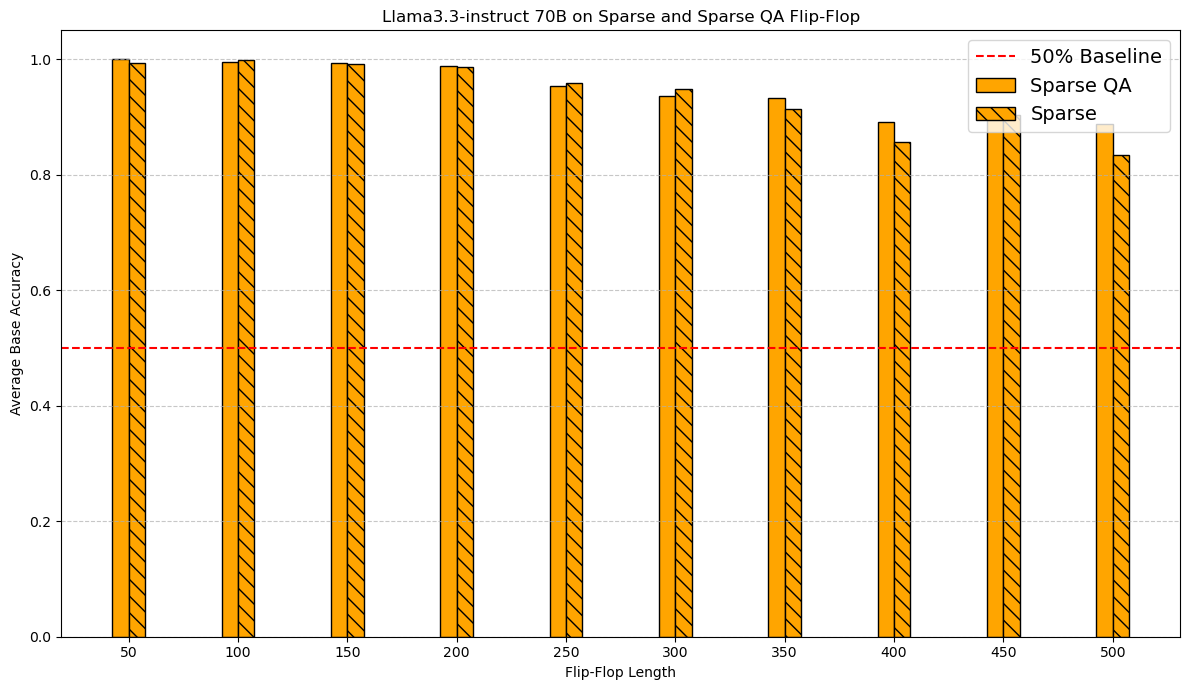

In [145]:
models = {
    "Sparse QA": ["llama3.3_70B-instruct/sparse-qa/s1", 
                          "llama3.3_70B-instruct/sparse-qa/s2", 
                          "llama3.3_70B-instruct/sparse-qa/s3", 
                          "llama3.3_70B-instruct/sparse-qa/s4", 
                          "llama3.3_70B-instruct/sparse-qa/s5"],
    "Sparse": ["llama3.3_70B-instruct/sparse/s1", 
                 "llama3.3_70B-instruct/sparse/s2", 
                 "llama3.3_70B-instruct/sparse/s3", 
                 "llama3.3_70B-instruct/sparse/s4", 
                 "llama3.3_70B-instruct/sparse/s5"]
}
title = "Llama3.3-instruct 70B on Sparse and Sparse QA Flip-Flop"
output_path = "graphs/llama3.3-instruct_70b_across_sparse_flipflop.png"
plot_per_model_sparse_accuracy(models, title, output_path, base_color="orange", fig_width=12)

# Llama 3.1-instruct 8B on all sparse subtasks

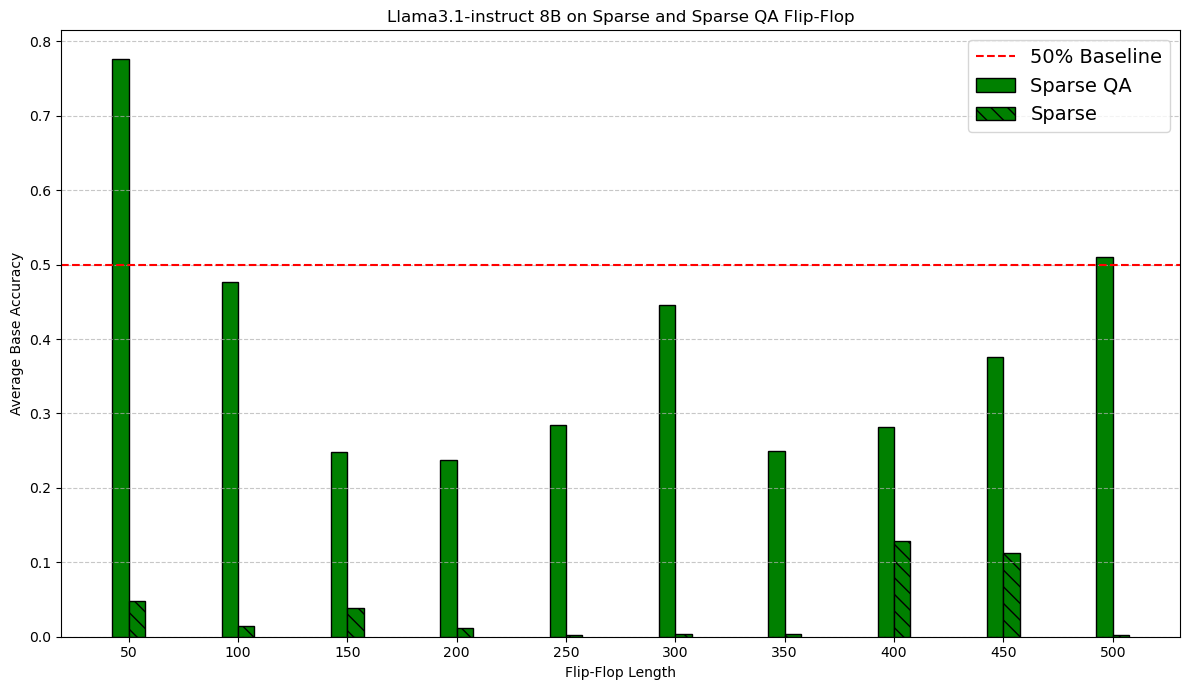

In [146]:
models = {
    "Sparse QA": ["llama3.1_8B-instruct/sparse-qa/s1", 
                          "llama3.1_8B-instruct/sparse-qa/s2", 
                          "llama3.1_8B-instruct/sparse-qa/s3", 
                          "llama3.1_8B-instruct/sparse-qa/s4", 
                          "llama3.1_8B-instruct/sparse-qa/s5"],
    "Sparse": ["llama3.1_8B-instruct/sparse/s1", 
                 "llama3.1_8B-instruct/sparse/s2", 
                 "llama3.1_8B-instruct/sparse/s3", 
                 "llama3.1_8B-instruct/sparse/s4", 
                 "llama3.1_8B-instruct/sparse/s5"]
}
title = "Llama3.1-instruct 8B on Sparse and Sparse QA Flip-Flop"
output_path = "graphs/llama3.1-instruct_8b_across_sparse_flipflop.png"
plot_per_model_sparse_accuracy(models, title, output_path, base_color="green", fig_width=12)

# Llama 3.1 8B on all sparse subtasks

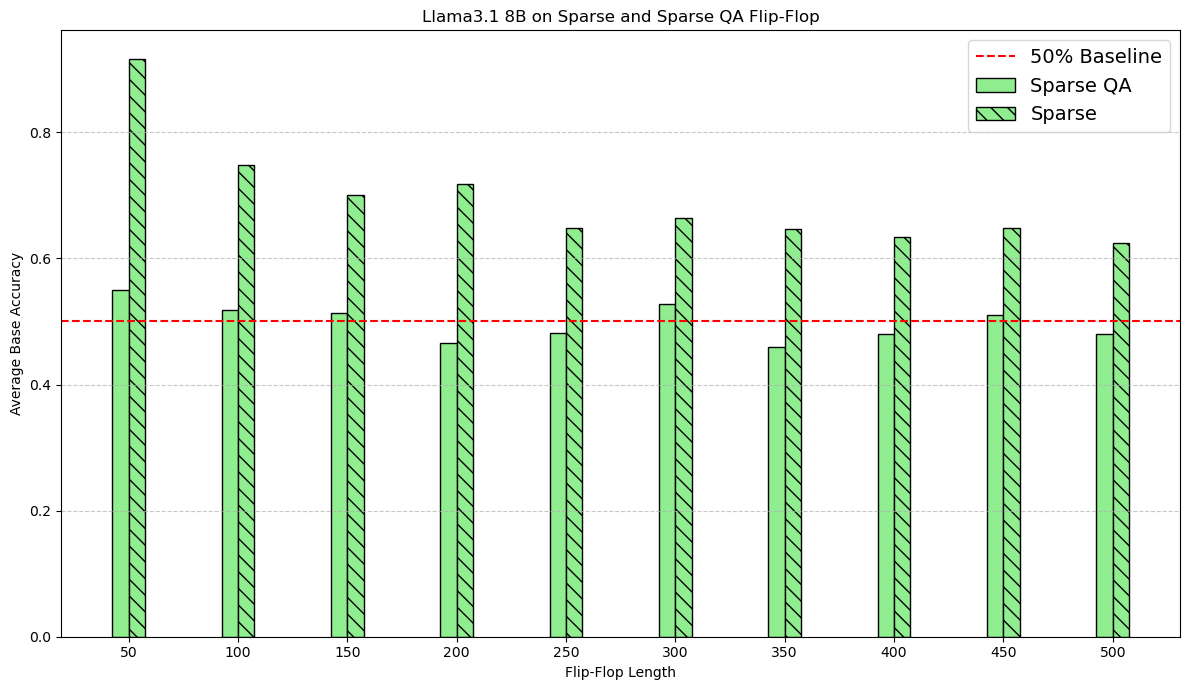

In [147]:
models = {
    "Sparse QA": ["llama3.1_8B/sparse-qa/s1", 
                          "llama3.1_8B/sparse-qa/s2", 
                          "llama3.1_8B/sparse-qa/s3", 
                          "llama3.1_8B/sparse-qa/s4", 
                          "llama3.1_8B/sparse-qa/s5"],
    "Sparse": ["llama3.1_8B/sparse/s1", 
                 "llama3.1_8B/sparse/s2", 
                 "llama3.1_8B/sparse/s3", 
                 "llama3.1_8B/sparse/s4", 
                 "llama3.1_8B/sparse/s5"]
}
title = "Llama3.1 8B on Sparse and Sparse QA Flip-Flop"
output_path = "graphs/llama3.1_8b_across_sparse_flipflop.png"
plot_per_model_sparse_accuracy(models, title, output_path, base_color="lightgreen", fig_width=12)

# OLMo 7B on all substasks

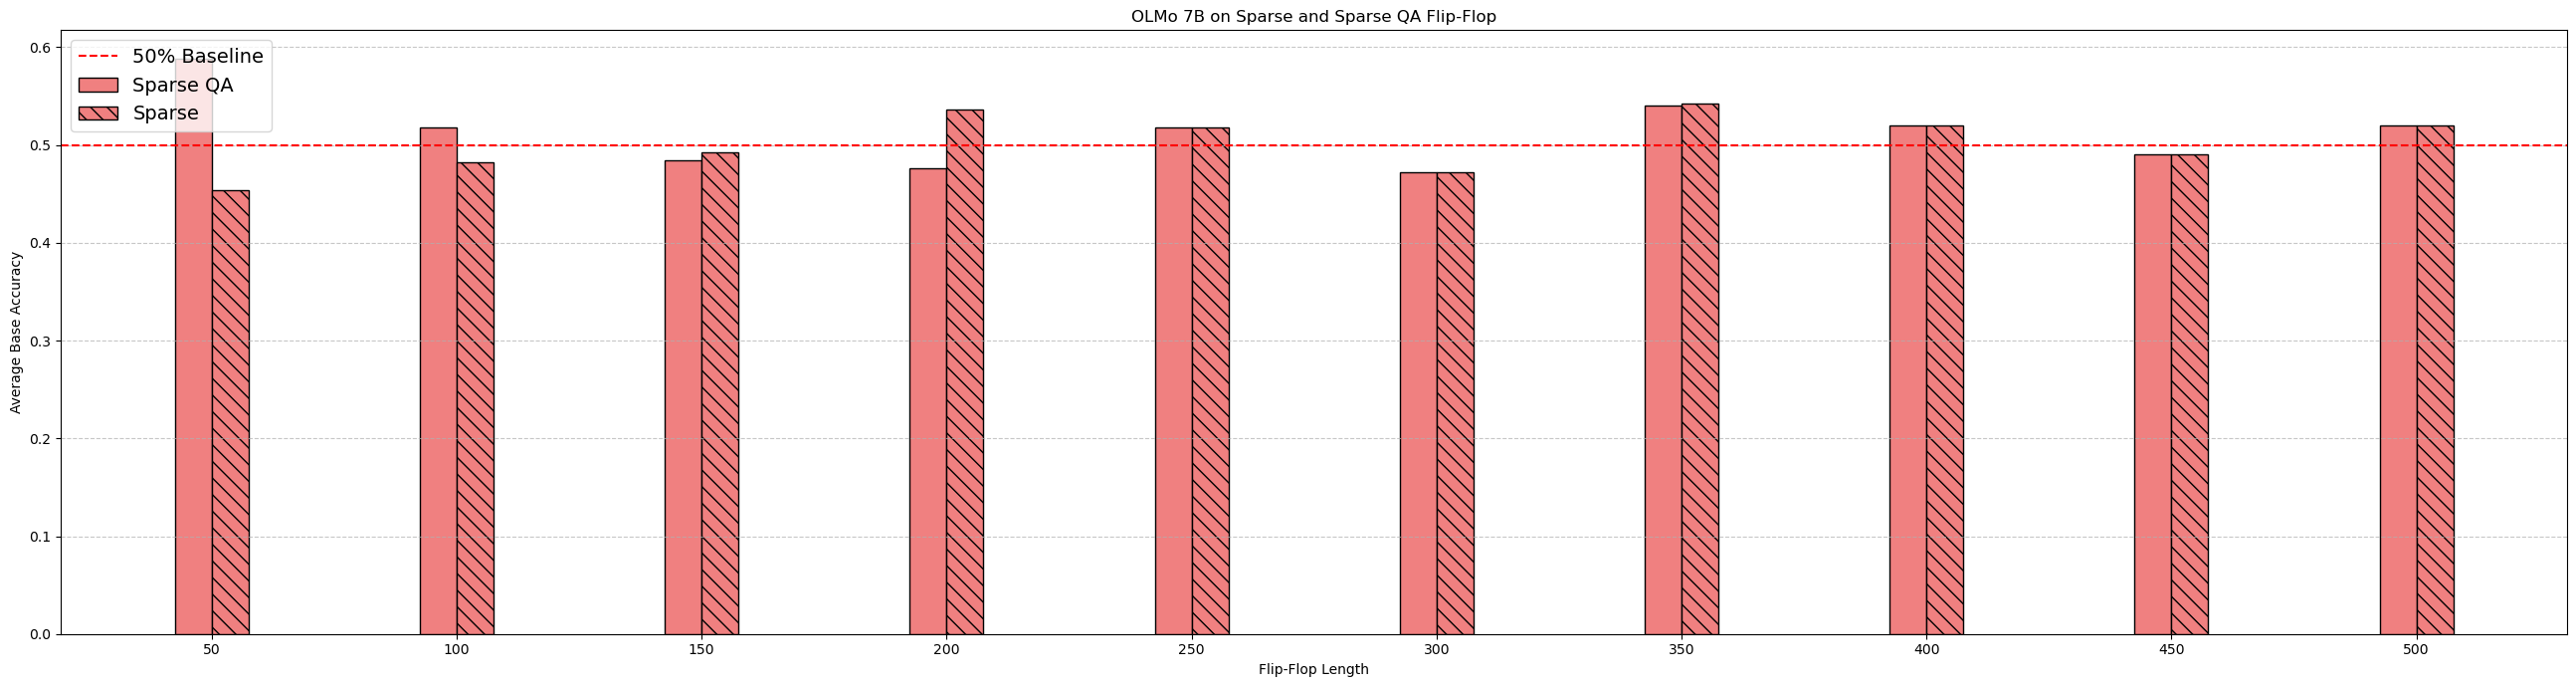

In [148]:
models = {
    "Sparse QA": ["OLMo_7B/sparse-qa/s1", 
                          "OLMo_7B/sparse-qa/s2", 
                          "OLMo_7B/sparse-qa/s3", 
                          "OLMo_7B/sparse-qa/s4", 
                          "OLMo_7B/sparse-qa/s5"],
    "Sparse": ["OLMo_7B/sparse/s1", 
                          "OLMo_7B/sparse/s2", 
                          "OLMo_7B/sparse/s3", 
                          "OLMo_7B/sparse/s4", 
                          "OLMo_7B/sparse/s5"],
}

title = "OLMo 7B on Sparse and Sparse QA Flip-Flop"
output_path = "graphs/olmo_7b_across_sparse_flipflop.png"
plot_per_model_sparse_accuracy(models, title, output_path, base_color="lightcoral")

# OLMo-instruct 7B on all subtasks

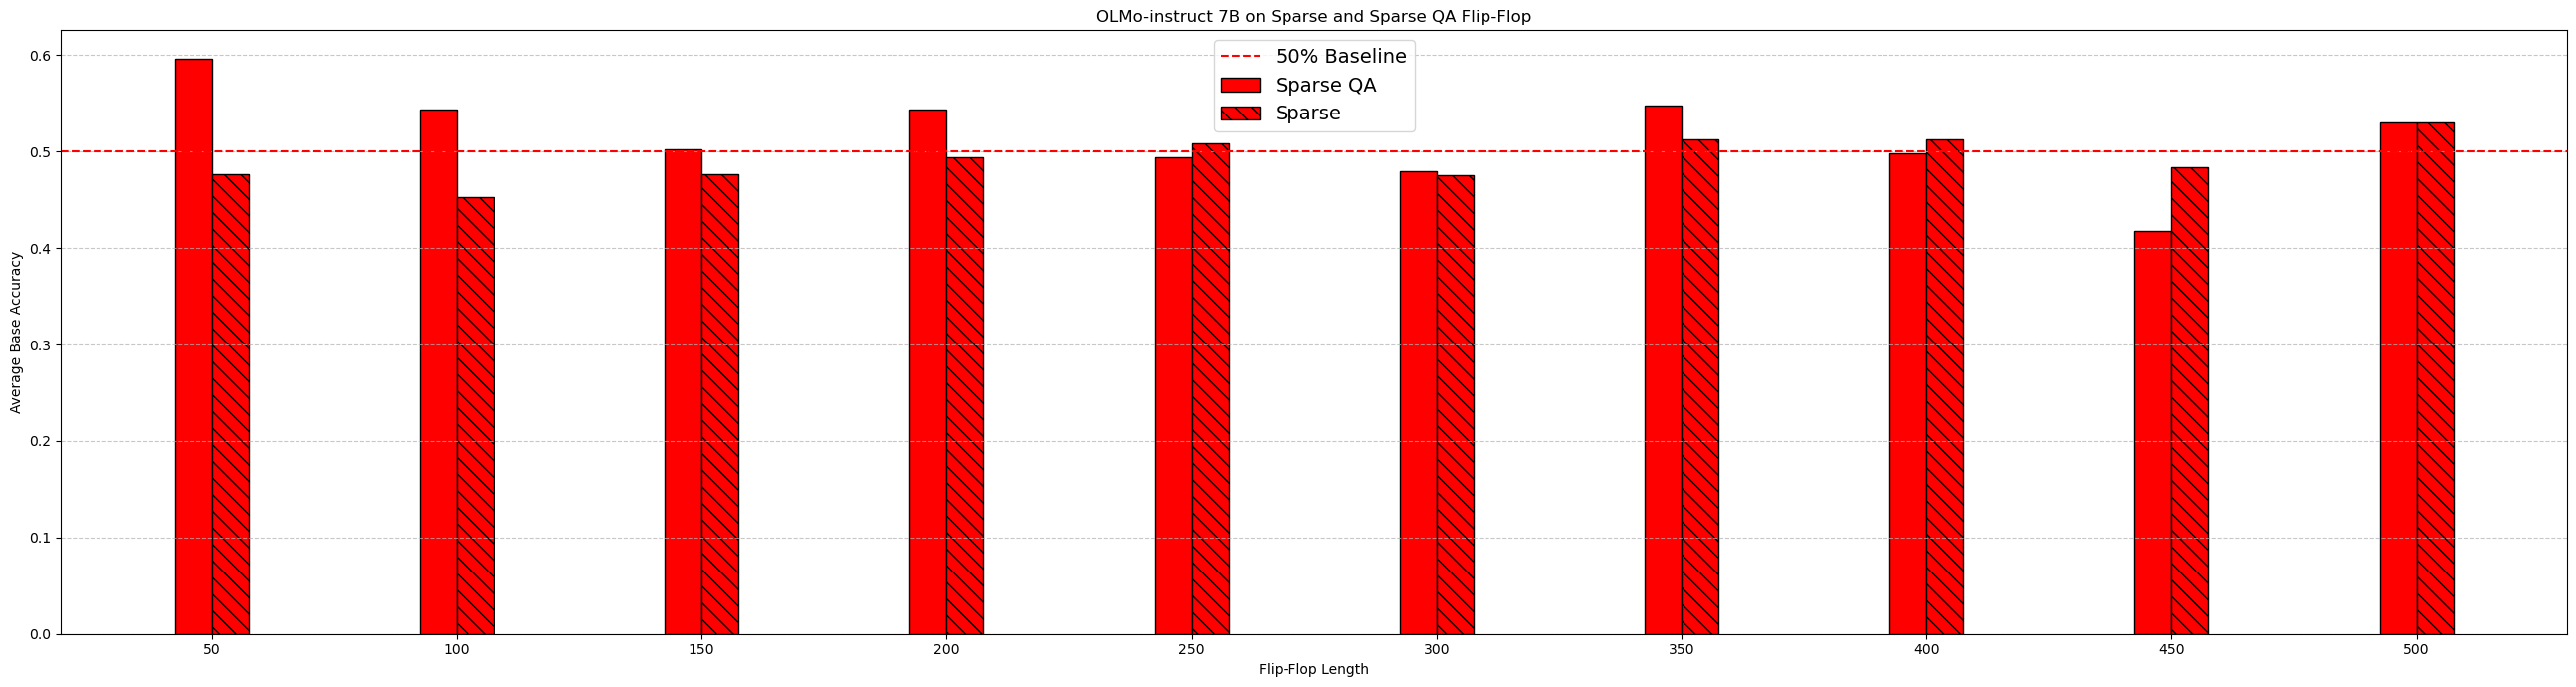

In [149]:
models = {
    "Sparse QA": ["OLMo_7B-instruct/sparse-qa/s1", 
                          "OLMo_7B-instruct/sparse-qa/s2",
                            "OLMo_7B-instruct/sparse-qa/s3", 
                          "OLMo_7B-instruct/sparse-qa/s4", 
                          "OLMo_7B-instruct/sparse-qa/s5"],
    "Sparse": ["OLMo_7B-instruct/sparse/s1", 
                          "OLMo_7B-instruct/sparse/s2", 
                          "OLMo_7B-instruct/sparse/s3", 
                          "OLMo_7B-instruct/sparse/s4", 
                          "OLMo_7B-instruct/sparse/s5"],
}
title = "OLMo-instruct 7B on Sparse and Sparse QA Flip-Flop"
output_path = "graphs/olmo-instruct_7b_across_sparse_flipflop.png"
plot_per_model_sparse_accuracy(models, title, output_path, base_color="red")

# OLMo2 7B on all subtasks

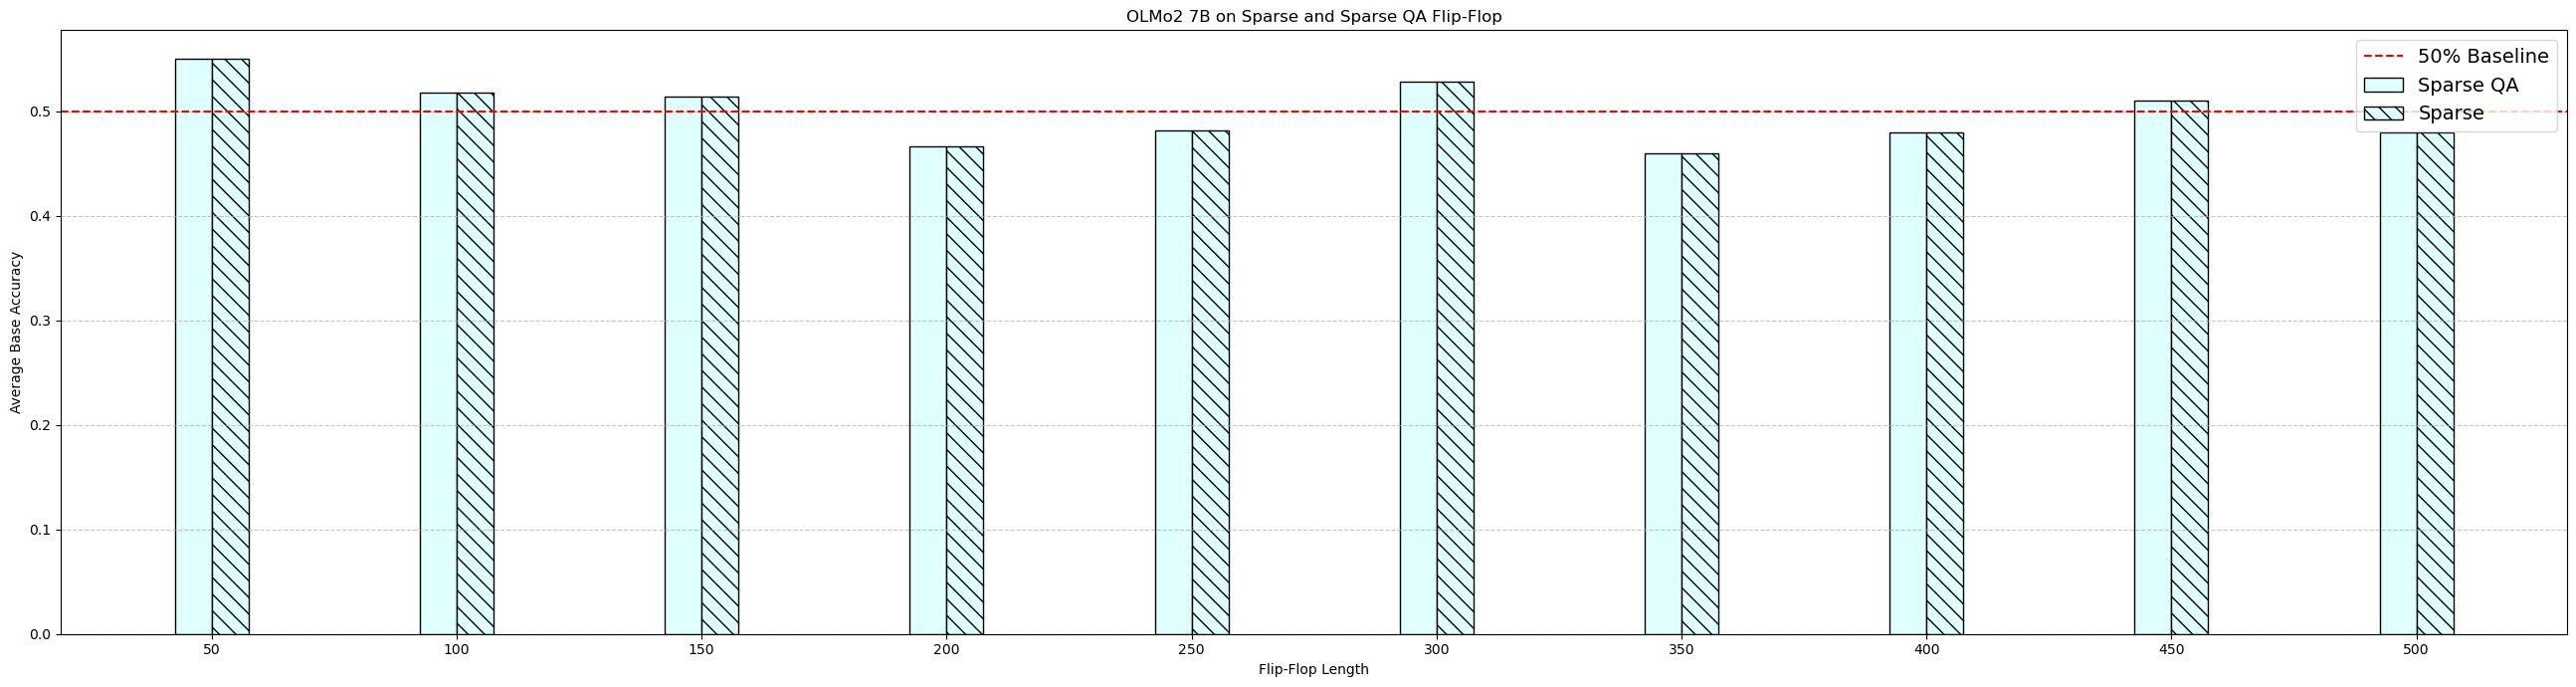

In [150]:
models = {
    "Sparse QA": ["OLMo2_7B/sparse-qa/s1", 
                          "OLMo2_7B/sparse-qa/s2", 
                            "OLMo2_7B/sparse-qa/s3", 
                          "OLMo2_7B/sparse-qa/s4", 
                          "OLMo2_7B/sparse-qa/s5"],
                        "Sparse": ["OLMo2_7B/sparse/s1", 
                          "OLMo2_7B/sparse/s2", 
                          "OLMo2_7B/sparse/s3", 
                          "OLMo2_7B/sparse/s4", 
                          "OLMo2_7B/sparse/s5"],
}
title = "OLMo2 7B on Sparse and Sparse QA Flip-Flop"
output_path = "graphs/olmo2_7b_across_sparse_flipflop.png"
plot_per_model_sparse_accuracy(models, title, output_path, base_color="lightcyan")

# OLMo2-instruct 7B on all subtasks

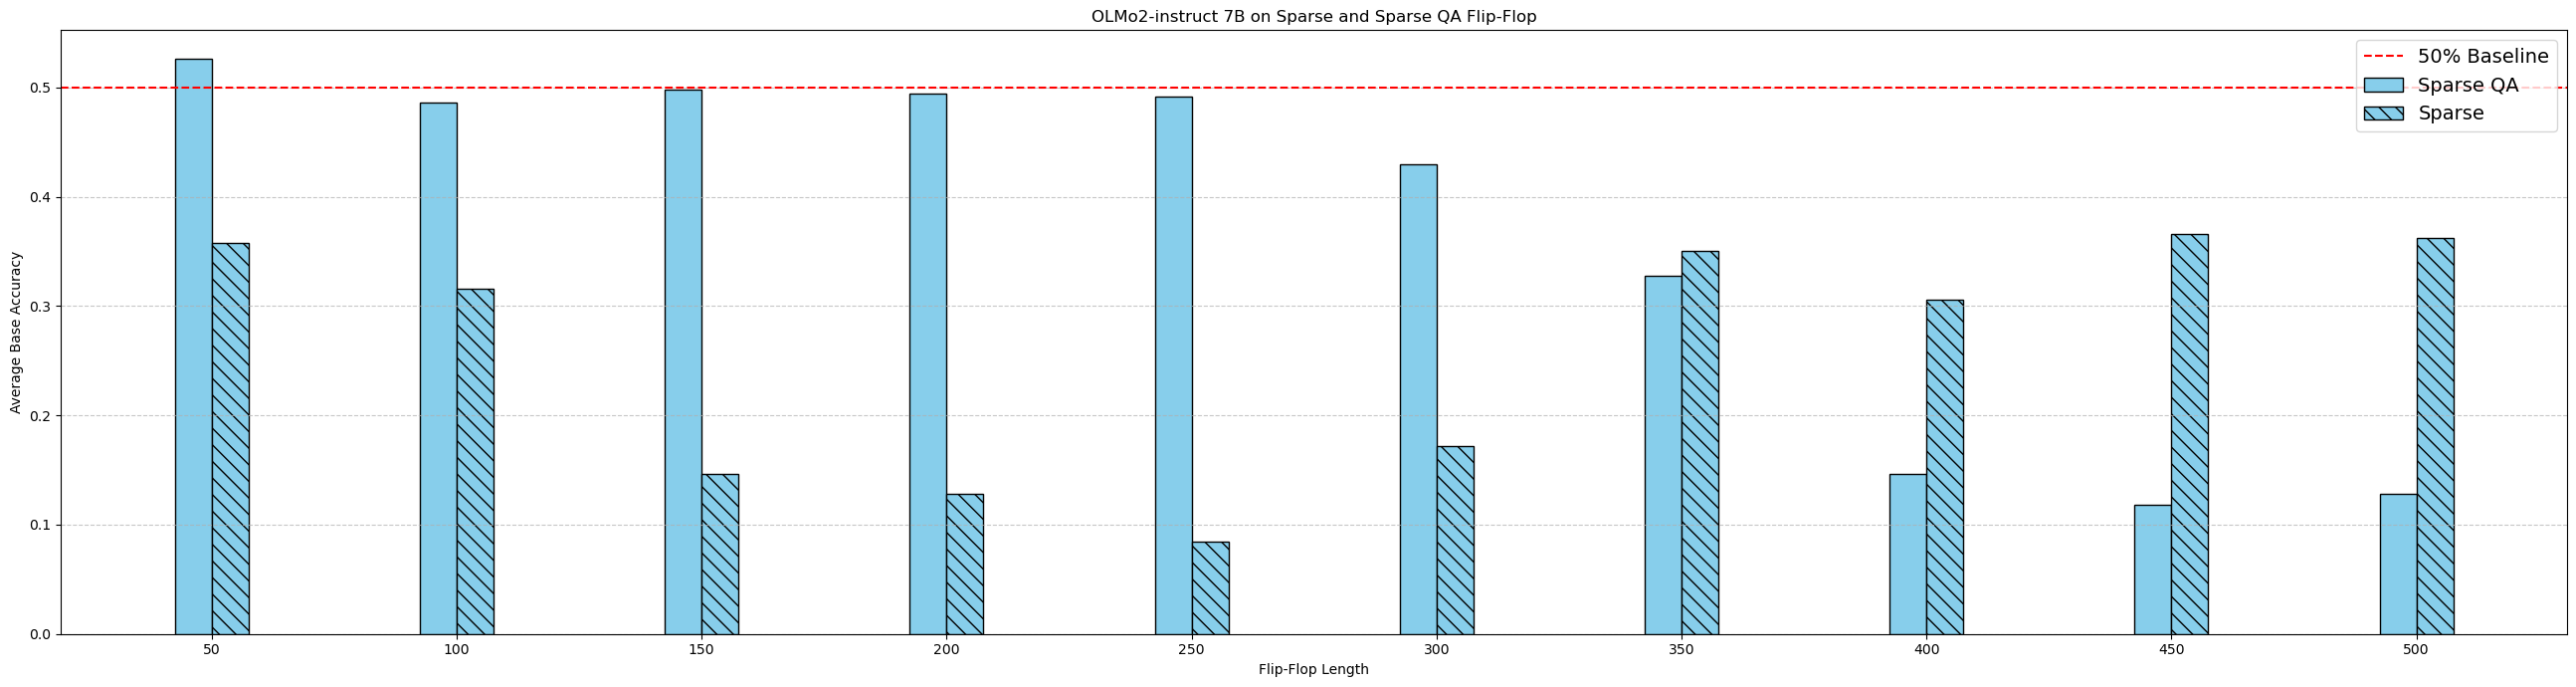

In [151]:
models = {
    "Sparse QA": ["OLMo2_7B-instruct/sparse-qa/s1", 
                          "OLMo2_7B-instruct/sparse-qa/s2", 
                            "OLMo2_7B-instruct/sparse-qa/s3", 
                          "OLMo2_7B-instruct/sparse-qa/s4", 
                          "OLMo2_7B-instruct/sparse-qa/s5"],
                        "Sparse": ["OLMo2_7B-instruct/sparse/s1", 
                          "OLMo2_7B-instruct/sparse/s2", 
                          "OLMo2_7B-instruct/sparse/s3", 
                          "OLMo2_7B-instruct/sparse/s4", 
                          "OLMo2_7B-instruct/sparse/s5"],
}
title = "OLMo2-instruct 7B on Sparse and Sparse QA Flip-Flop"
output_path = "graphs/olmo2-instruct_7b_across_sparse_flipflop.png"
plot_per_model_sparse_accuracy(models, title, output_path, base_color="skyblue")

# OLMo2 13B on all subtasks

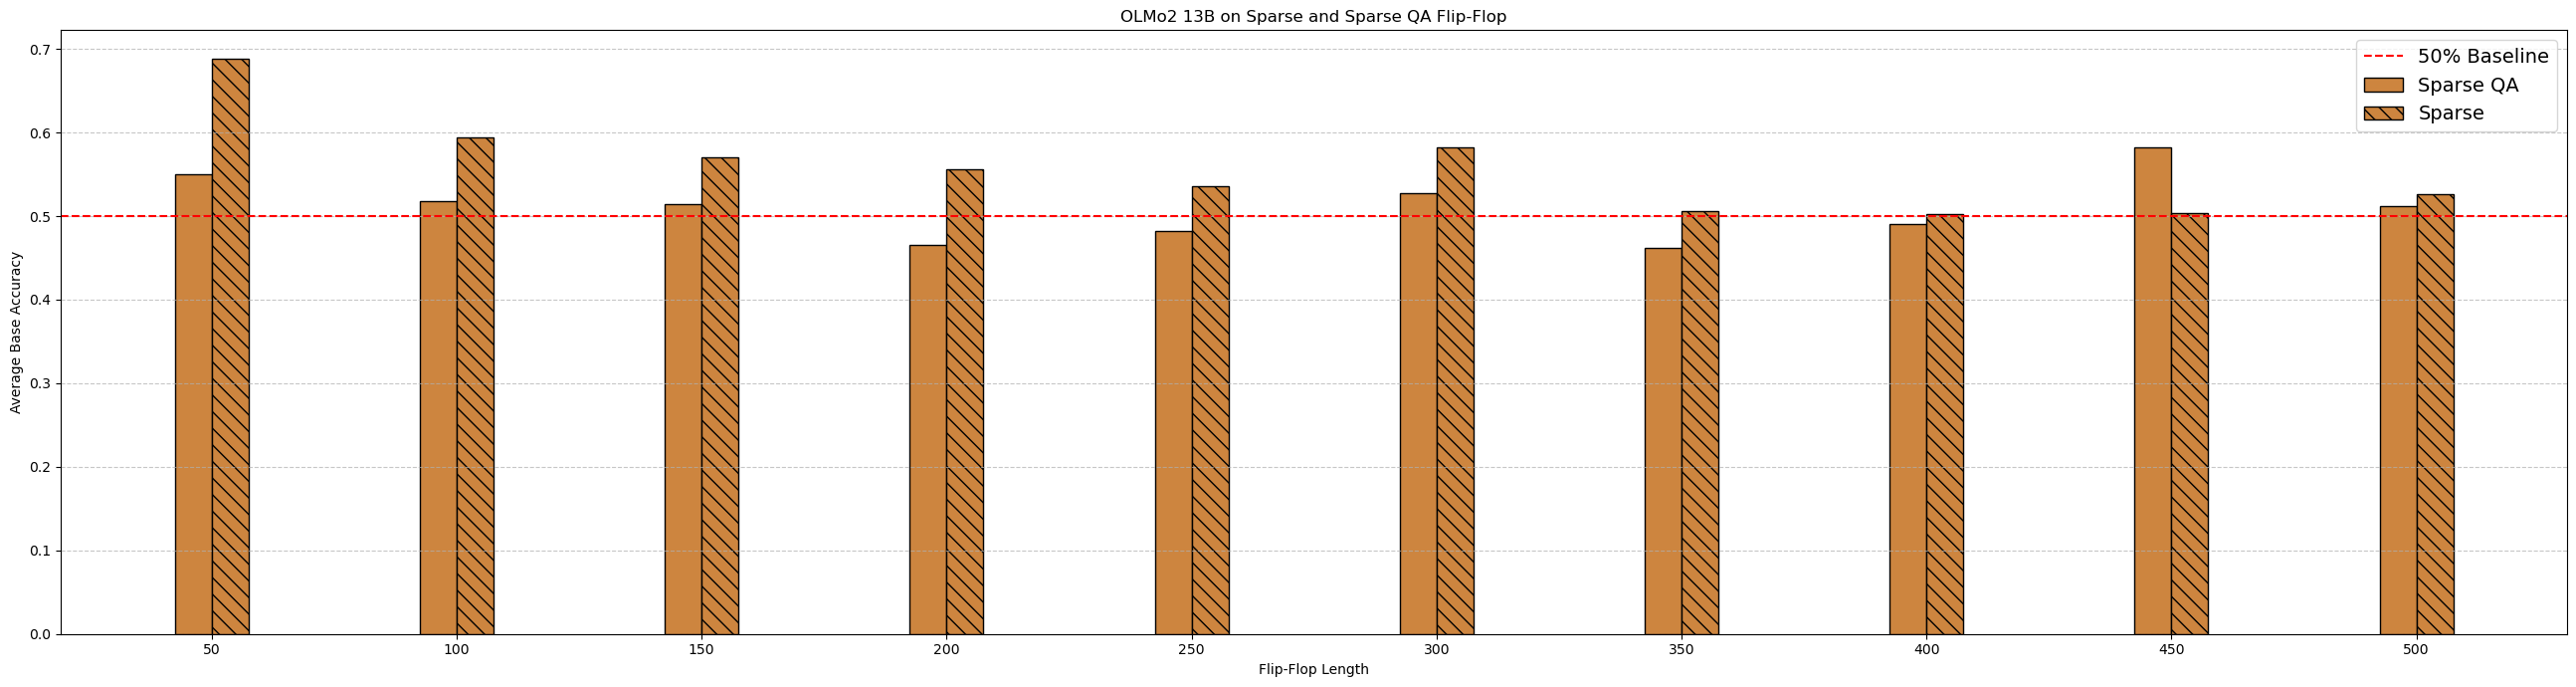

In [152]:
models = {
    "Sparse QA": ["OLMo2_13B/sparse-qa/s1", 
                          "OLMo2_13B/sparse-qa/s2", 
                            "OLMo2_13B/sparse-qa/s3", 
                          "OLMo2_13B/sparse-qa/s4", 
                          "OLMo2_13B/sparse-qa/s5"],
                        "Sparse": ["OLMo2_13B/sparse/s1", 
                          "OLMo2_13B/sparse/s2", 
                          "OLMo2_13B/sparse/s3", 
                          "OLMo2_13B/sparse/s4", 
                          "OLMo2_13B/sparse/s5"],
}
title = "OLMo2 13B on Sparse and Sparse QA Flip-Flop"
output_path = "graphs/olmo2_13b_across_sparse_flipflop.png"
plot_per_model_sparse_accuracy(models, title, output_path, base_color="peru")

# OLMo2-instruct 13B on all subtasks

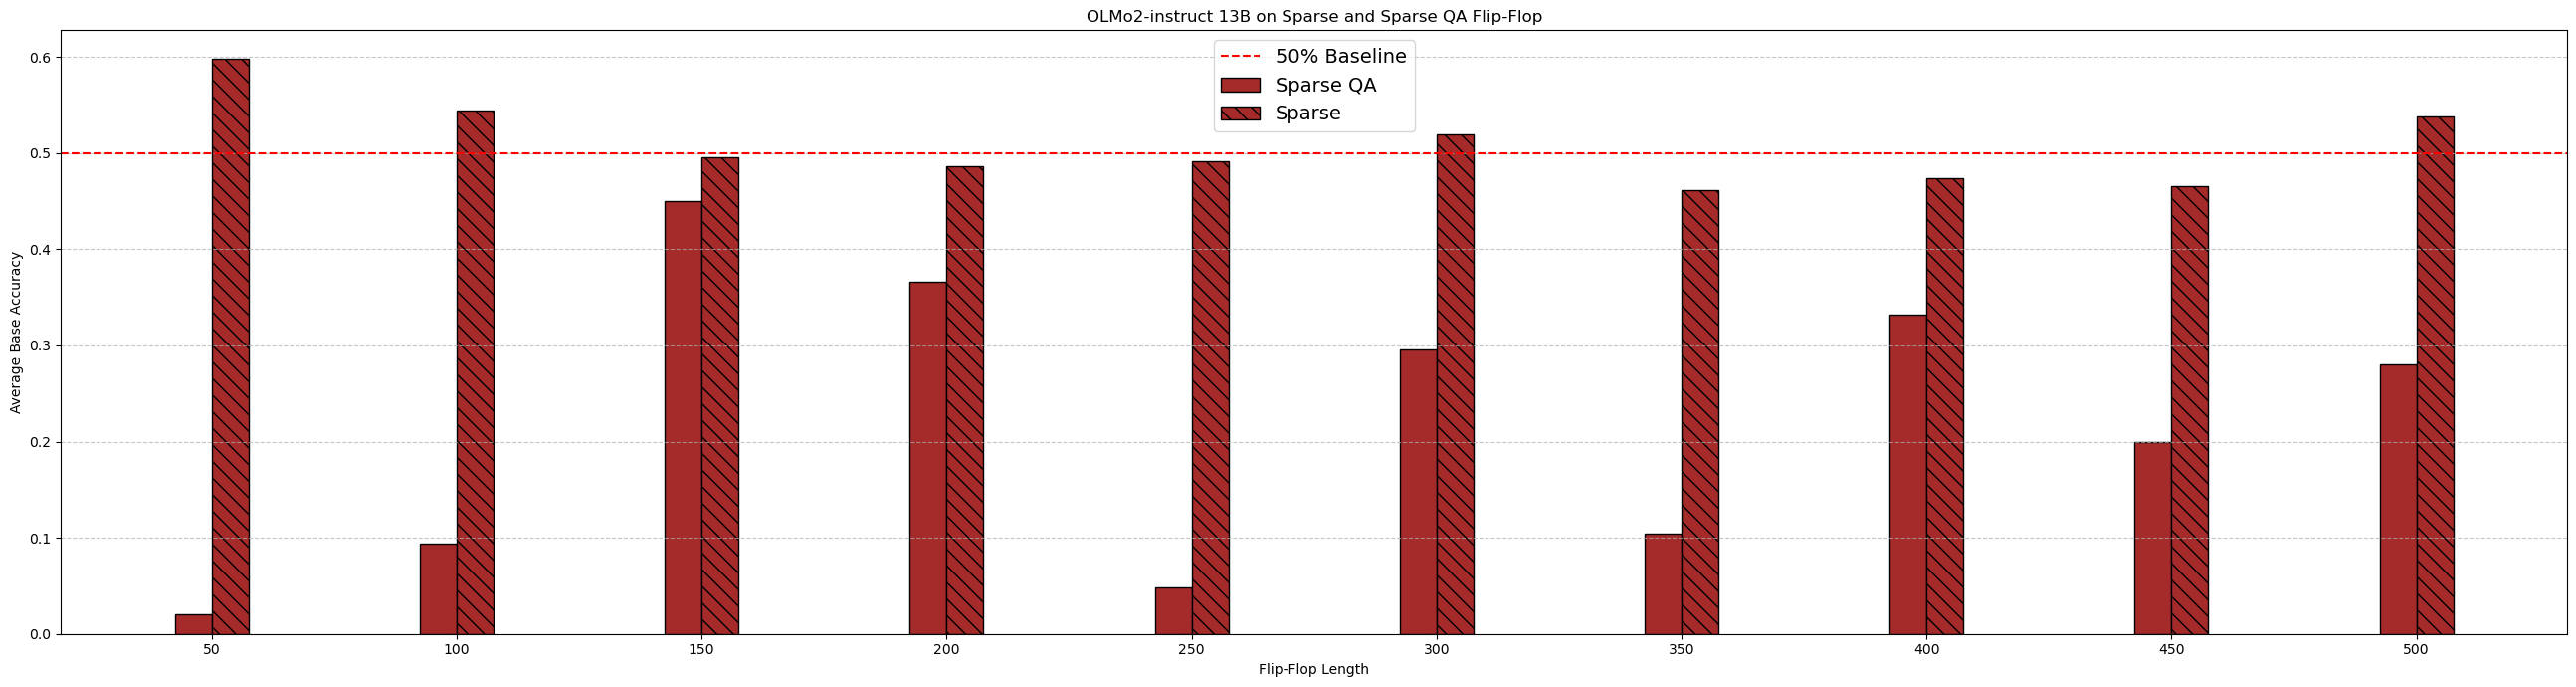

In [153]:
models = {
    "Sparse QA": ["OLMo2_13B-instruct/sparse-qa/s1", 
                          "OLMo2_13B-instruct/sparse-qa/s2", 
                            "OLMo2_13B-instruct/sparse-qa/s3", 
                          "OLMo2_13B-instruct/sparse-qa/s4", 
                          "OLMo2_13B-instruct/sparse-qa/s5"],
                        "Sparse": ["OLMo2_13B-instruct/sparse/s1", 
                          "OLMo2_13B-instruct/sparse/s2", 
                          "OLMo2_13B-instruct/sparse/s3", 
                          "OLMo2_13B-instruct/sparse/s4", 
                          "OLMo2_13B-instruct/sparse/s5"],
}
title = "OLMo2-instruct 13B on Sparse and Sparse QA Flip-Flop"
output_path = "graphs/olmo2-instruct_13b_across_sparse_flipflop.png"
plot_per_model_sparse_accuracy(models, title, output_path, base_color="brown")

# All Llamas together

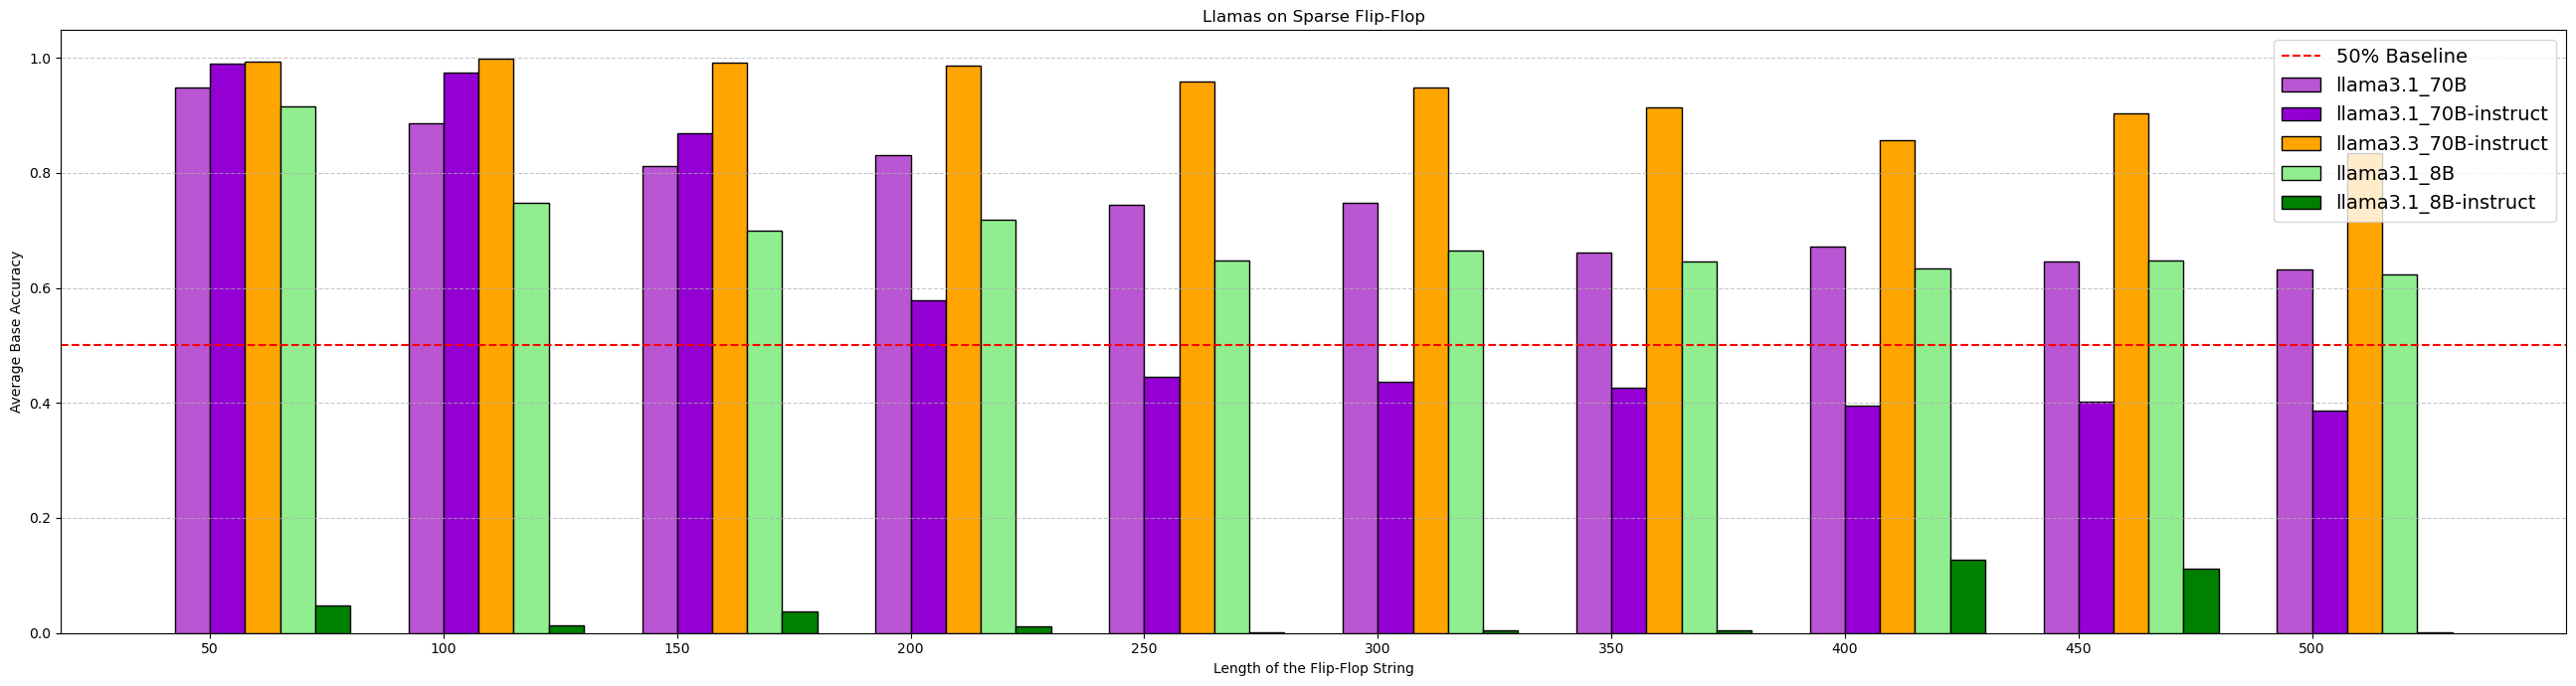

In [154]:
# SPARSE
models = {
    "llama3.1_70B": ["llama3.1_70B/sparse/s1", 
                          "llama3.1_70B/sparse/s2", 
                          "llama3.1_70B/sparse/s3", 
                          "llama3.1_70B/sparse/s4", 
                          "llama3.1_70B/sparse/s5"],
    "llama3.1_70B-instruct": ["llama3.1_70B-instruct/sparse/s1", 
                 "llama3.1_70B-instruct/sparse/s2", 
                 "llama3.1_70B-instruct/sparse/s3", 
                 "llama3.1_70B-instruct/sparse/s4", 
                 "llama3.1_70B-instruct/sparse/s5"],
    "llama3.3_70B-instruct": ["llama3.3_70B-instruct/sparse/s1", 
                 "llama3.3_70B-instruct/sparse/s2", 
                 "llama3.3_70B-instruct/sparse/s3", 
                 "llama3.3_70B-instruct/sparse/s4", 
                 "llama3.3_70B-instruct/sparse/s5"],
        "llama3.1_8B": ["llama3.1_8B/sparse/s1", 
                 "llama3.1_8B/sparse/s2", 
                 "llama3.1_8B/sparse/s3", 
                 "llama3.1_8B/sparse/s4", 
                 "llama3.1_8B/sparse/s5"],
    "llama3.1_8B-instruct": ["llama3.1_8B-instruct/sparse/s1", 
                          "llama3.1_8B-instruct/sparse/s2", 
                          "llama3.1_8B-instruct/sparse/s3", 
                          "llama3.1_8B-instruct/sparse/s4", 
                          "llama3.1_8B-instruct/sparse/s5"]
}
title = "Llamas on Sparse Flip-Flop"
output_path = "graphs/llamas_across_sparse_flipflop.png"
x_axis_text = "Length of the Flip-Flop String"
plot_sparse_accuracy(models, title, output_path, x_axis_text=x_axis_text)

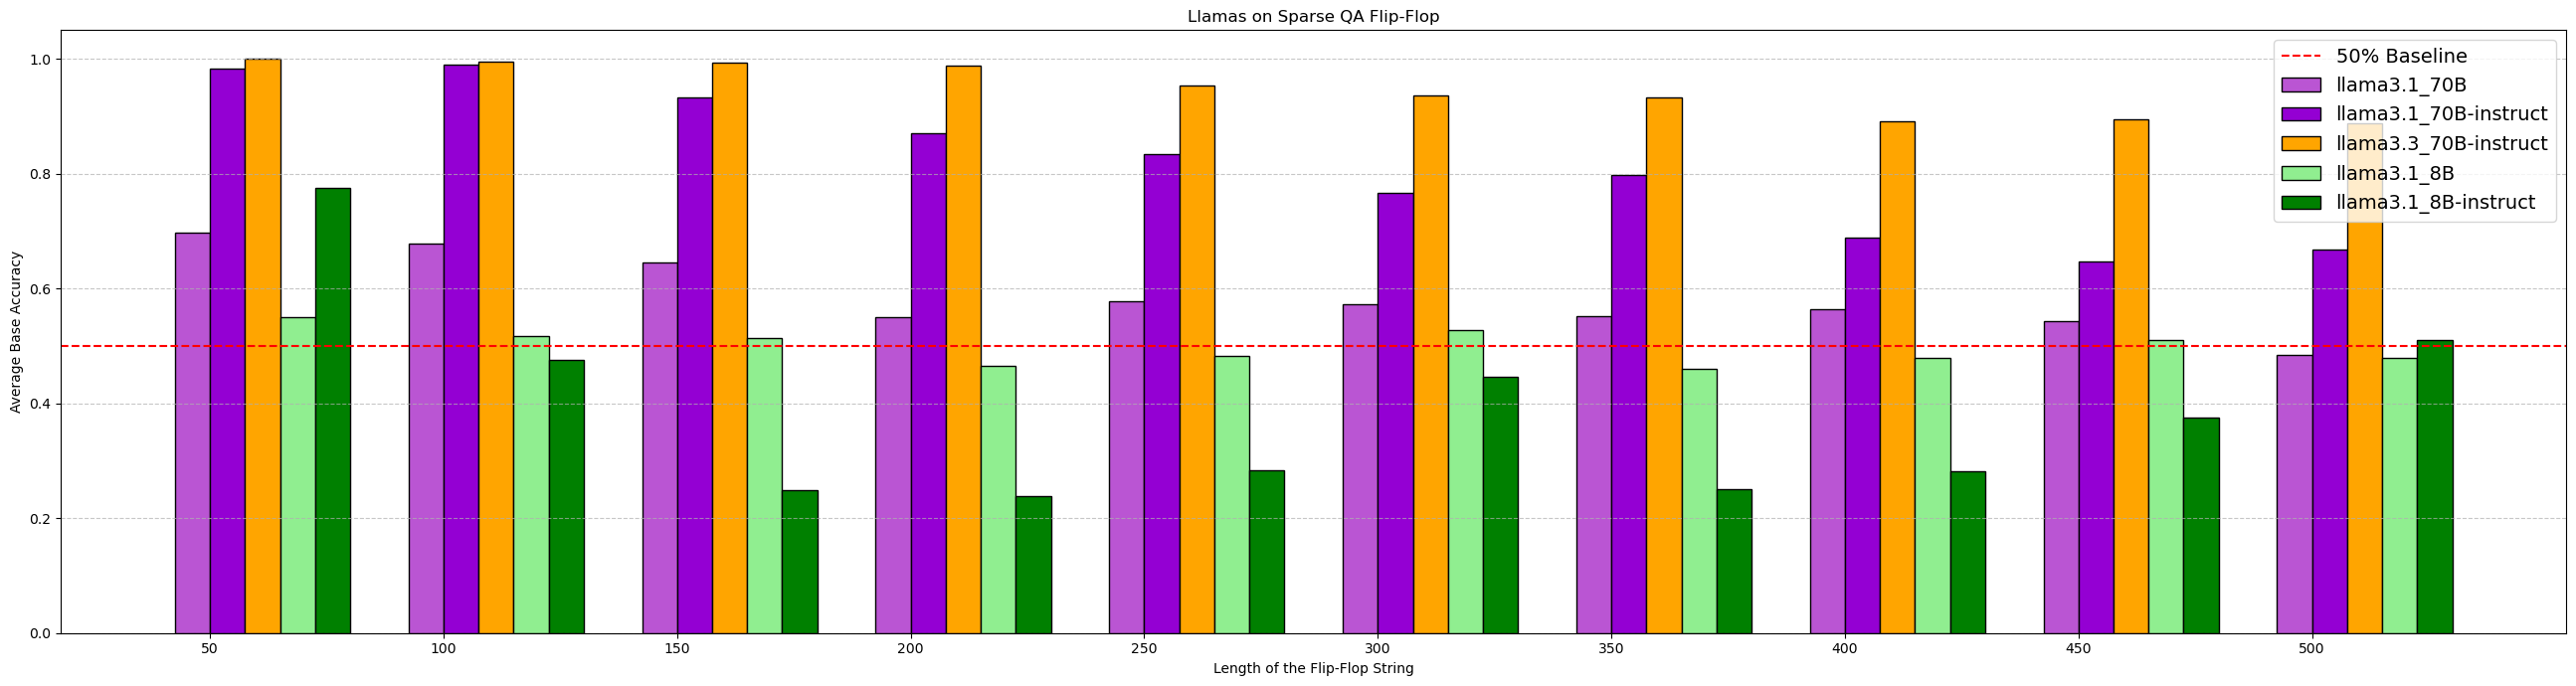

In [155]:
# SPARSE QA
models = {
    "llama3.1_70B": ["llama3.1_70B/sparse-qa/s1", 
                          "llama3.1_70B/sparse-qa/s2", 
                          "llama3.1_70B/sparse-qa/s3", 
                          "llama3.1_70B/sparse-qa/s4", 
                          "llama3.1_70B/sparse-qa/s5"],
    "llama3.1_70B-instruct": ["llama3.1_70B-instruct/sparse-qa/s1", 
                 "llama3.1_70B-instruct/sparse-qa/s2", 
                 "llama3.1_70B-instruct/sparse-qa/s3", 
                 "llama3.1_70B-instruct/sparse-qa/s4", 
                 "llama3.1_70B-instruct/sparse-qa/s5"],
    "llama3.3_70B-instruct": ["llama3.3_70B-instruct/sparse-qa/s1", 
                 "llama3.3_70B-instruct/sparse-qa/s2", 
                 "llama3.3_70B-instruct/sparse-qa/s3", 
                 "llama3.3_70B-instruct/sparse-qa/s4", 
                 "llama3.3_70B-instruct/sparse-qa/s5"],
        "llama3.1_8B": ["llama3.1_8B/sparse-qa/s1", 
                 "llama3.1_8B/sparse-qa/s2", 
                 "llama3.1_8B/sparse-qa/s3", 
                 "llama3.1_8B/sparse-qa/s4", 
                 "llama3.1_8B/sparse-qa/s5"],
    "llama3.1_8B-instruct": ["llama3.1_8B-instruct/sparse-qa/s1", 
                          "llama3.1_8B-instruct/sparse-qa/s2", 
                          "llama3.1_8B-instruct/sparse-qa/s3", 
                          "llama3.1_8B-instruct/sparse-qa/s4", 
                          "llama3.1_8B-instruct/sparse-qa/s5"],
}
title = "Llamas on Sparse QA Flip-Flop"
output_path = "graphs/llamas_across_sparse_qa_flipflop.png"
x_axis_text = "Length of the Flip-Flop String"
plot_sparse_accuracy(models, title, output_path, x_axis_text=x_axis_text)

# All OLMos together

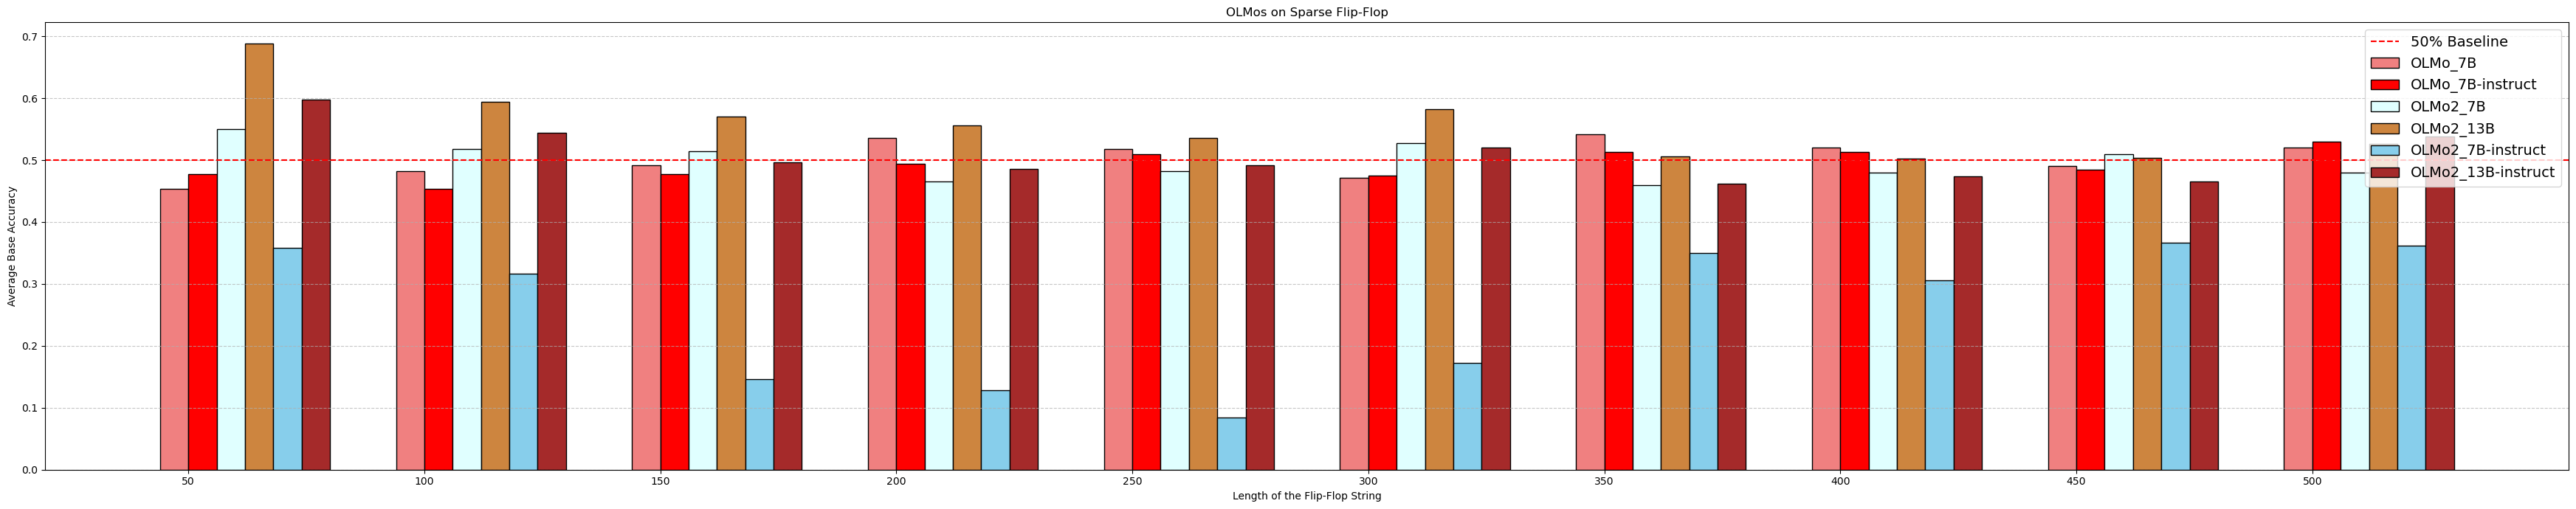

In [156]:
# SPARSE
models = {
    "OLMo_7B": ["OLMo_7B/sparse/s1", 
                          "OLMo_7B/sparse/s2", 
                          "OLMo_7B/sparse/s3", 
                          "OLMo_7B/sparse/s4", 
                          "OLMo_7B/sparse/s5"],
    "OLMo_7B-instruct": ["OLMo_7B-instruct/sparse/s1", 
                 "OLMo_7B-instruct/sparse/s2", 
                 "OLMo_7B-instruct/sparse/s3", 
                 "OLMo_7B-instruct/sparse/s4", 
                 "OLMo_7B-instruct/sparse/s5"],
        "OLMo2_7B": ["OLMo2_7B/sparse/s1", 
            "OLMo2_7B/sparse/s2",
            "OLMo2_7B/sparse/s3",
            "OLMo2_7B/sparse/s4",
            "OLMo2_7B/sparse/s5"],
    "OLMo2_13B": ["OLMo2_13B/sparse/s1", 
            "OLMo2_13B/sparse/s2",
            "OLMo2_13B/sparse/s3",
            "OLMo2_13B/sparse/s4",
            "OLMo2_13B/sparse/s5"],
    "OLMo2_7B-instruct": ["OLMo2_7B-instruct/sparse/s1", 
            "OLMo2_7B-instruct/sparse/s2",
            "OLMo2_7B-instruct/sparse/s3",
            "OLMo2_7B-instruct/sparse/s4",
            "OLMo2_7B-instruct/sparse/s5"],
    "OLMo2_13B-instruct": ["OLMo2_13B-instruct/sparse/s1", 
            "OLMo2_13B-instruct/sparse/s2",
            "OLMo2_13B-instruct/sparse/s3",
            "OLMo2_13B-instruct/sparse/s4",
            "OLMo2_13B-instruct/sparse/s5"]
}
title = "OLMos on Sparse Flip-Flop"
output_path = "graphs/olmos_across_sparse_flipflop.png"
x_axis_text = "Length of the Flip-Flop String"
plot_sparse_accuracy(models, title, output_path, fig_width=35, bar_width=0.12, x_axis_text=x_axis_text)

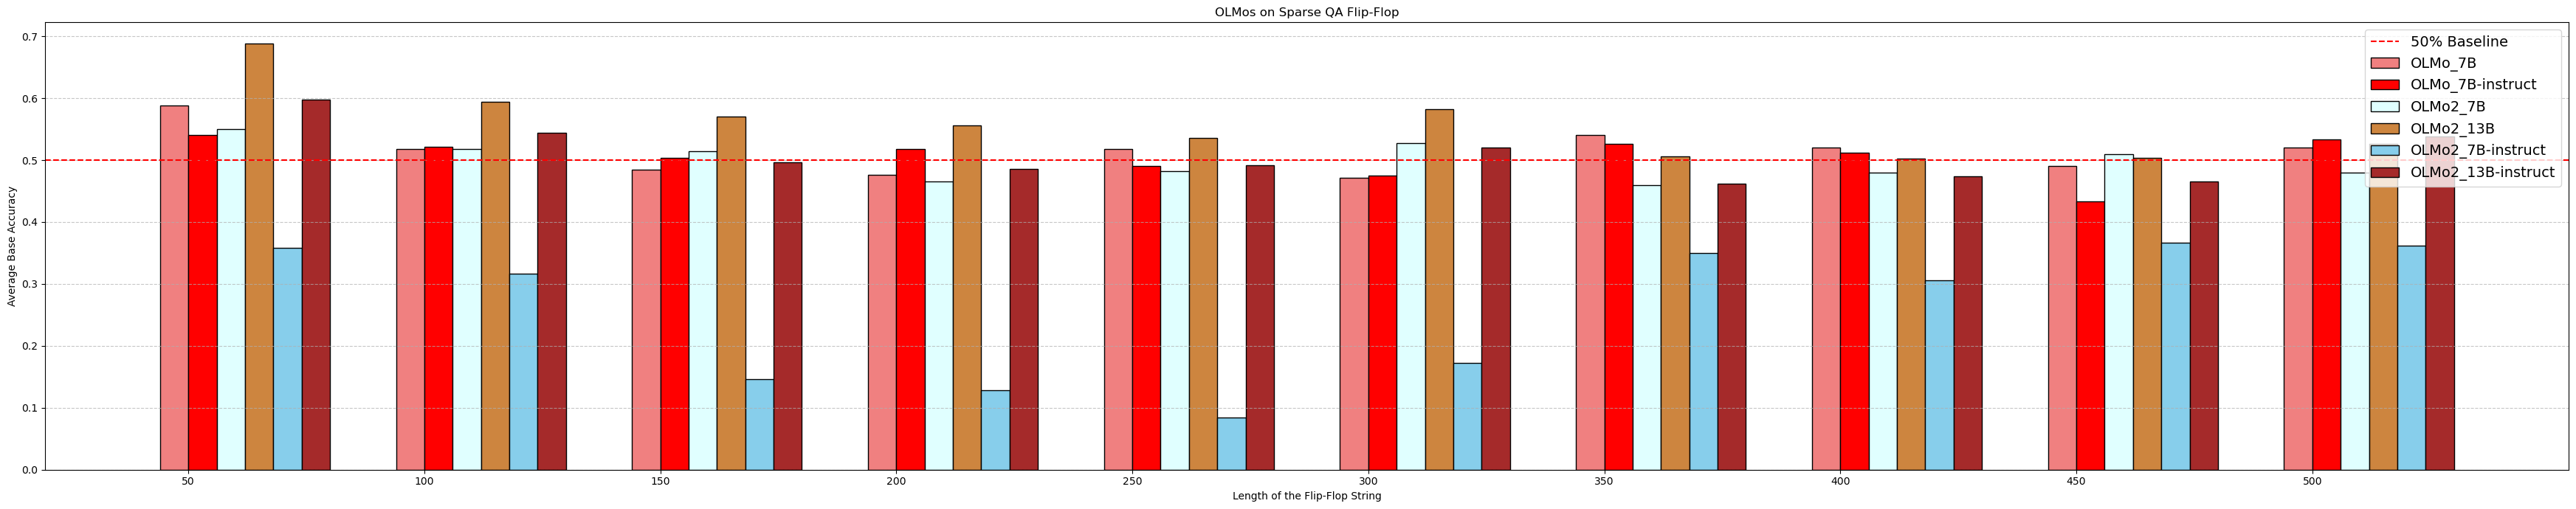

In [157]:
# SPARSE QA
models = {
    "OLMo_7B": ["OLMo_7B/sparse-qa/s1", 
                          "OLMo_7B/sparse-qa/s2", 
                          "OLMo_7B/sparse-qa/s3", 
                          "OLMo_7B/sparse-qa/s4", 
                          "OLMo_7B/sparse-qa/s5"],
    "OLMo_7B-instruct": ["OLMo_7B-instruct/sparse-qa/s1", 
                 "OLMo_7B-instruct/sparse-qa/s2", 
                 "OLMo_7B-instruct/sparse-qa/s3", 
                 "OLMo_7B-instruct/sparse-qa/s4", 
                 "OLMo_7B-instruct/sparse/s5"],
        "OLMo2_7B": ["OLMo2_7B/sparse/s1", 
            "OLMo2_7B/sparse/s2",
            "OLMo2_7B/sparse/s3",
            "OLMo2_7B/sparse/s4",
            "OLMo2_7B/sparse/s5"],
    "OLMo2_13B": ["OLMo2_13B/sparse/s1", 
            "OLMo2_13B/sparse/s2",
            "OLMo2_13B/sparse/s3",
            "OLMo2_13B/sparse/s4",
            "OLMo2_13B/sparse/s5"],
    "OLMo2_7B-instruct": ["OLMo2_7B-instruct/sparse/s1", 
            "OLMo2_7B-instruct/sparse/s2",
            "OLMo2_7B-instruct/sparse/s3",
            "OLMo2_7B-instruct/sparse/s4",
            "OLMo2_7B-instruct/sparse/s5"],
    "OLMo2_13B-instruct": ["OLMo2_13B-instruct/sparse/s1", 
            "OLMo2_13B-instruct/sparse/s2",
            "OLMo2_13B-instruct/sparse/s3",
            "OLMo2_13B-instruct/sparse/s4",
            "OLMo2_13B-instruct/sparse/s5"]
}
title = "OLMos on Sparse QA Flip-Flop"
output_path = "graphs/olmos_across_sparse_qa_flipflop.png"
x_axis_text = "Length of the Flip-Flop String"
plot_sparse_accuracy(models, title, output_path, fig_width=35, bar_width=0.12, x_axis_text=x_axis_text)

# DISTANCE

 ## LLama 3.1 70B on all subtasks

Distance: Loaded 295 entries from all folders.
Distance QA: Loaded 295 entries from all folders.


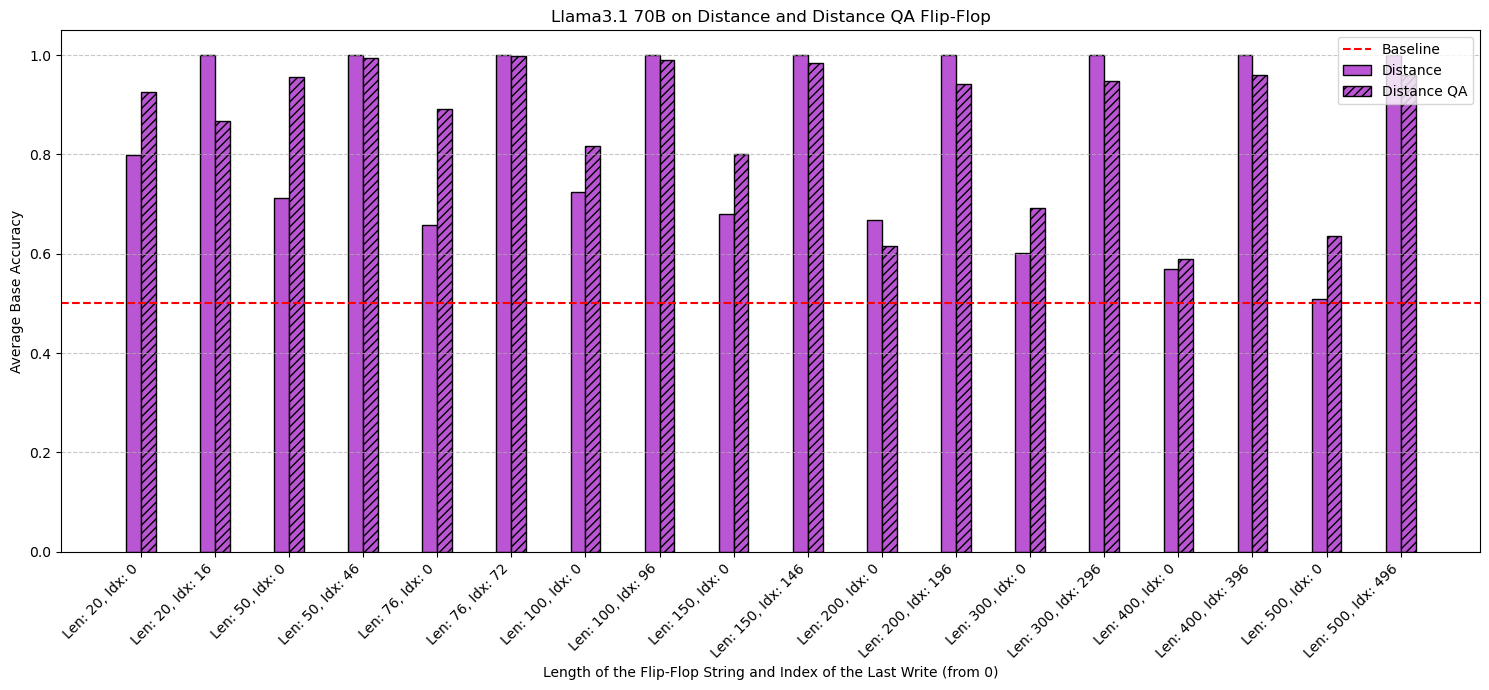

In [158]:
models = {
    "Distance": ["llama3.1_70B/distance/s1", 
                          "llama3.1_70B/distance/s2", 
                          "llama3.1_70B/distance/s3", 
                          "llama3.1_70B/distance/s4", 
                          "llama3.1_70B/distance/s5"],
        "Distance QA": ["llama3.1_70B/distance-qa/s1", 
                          "llama3.1_70B/distance-qa/s2", 
                          "llama3.1_70B/distance-qa/s3", 
                          "llama3.1_70B/distance-qa/s4", 
                          "llama3.1_70B/distance-qa/s5"],
}
title = "Llama3.1 70B on Distance and Distance QA Flip-Flop"
output_path = "graphs/llama3.1_70b_across_distance_flipflop.png"
x_axis_text = "Length of the Flip-Flop String and Index of the Last Write (from 0)"
plot_per_model_distance_accuracy(models, title, output_path, base_color="mediumorchid", x_axis_text=x_axis_text, fig_width=15, )

 ## LLama 3.1-instruct 70B on all subtasks

Distance: Loaded 590 entries from all folders.
Distance QA: Loaded 295 entries from all folders.


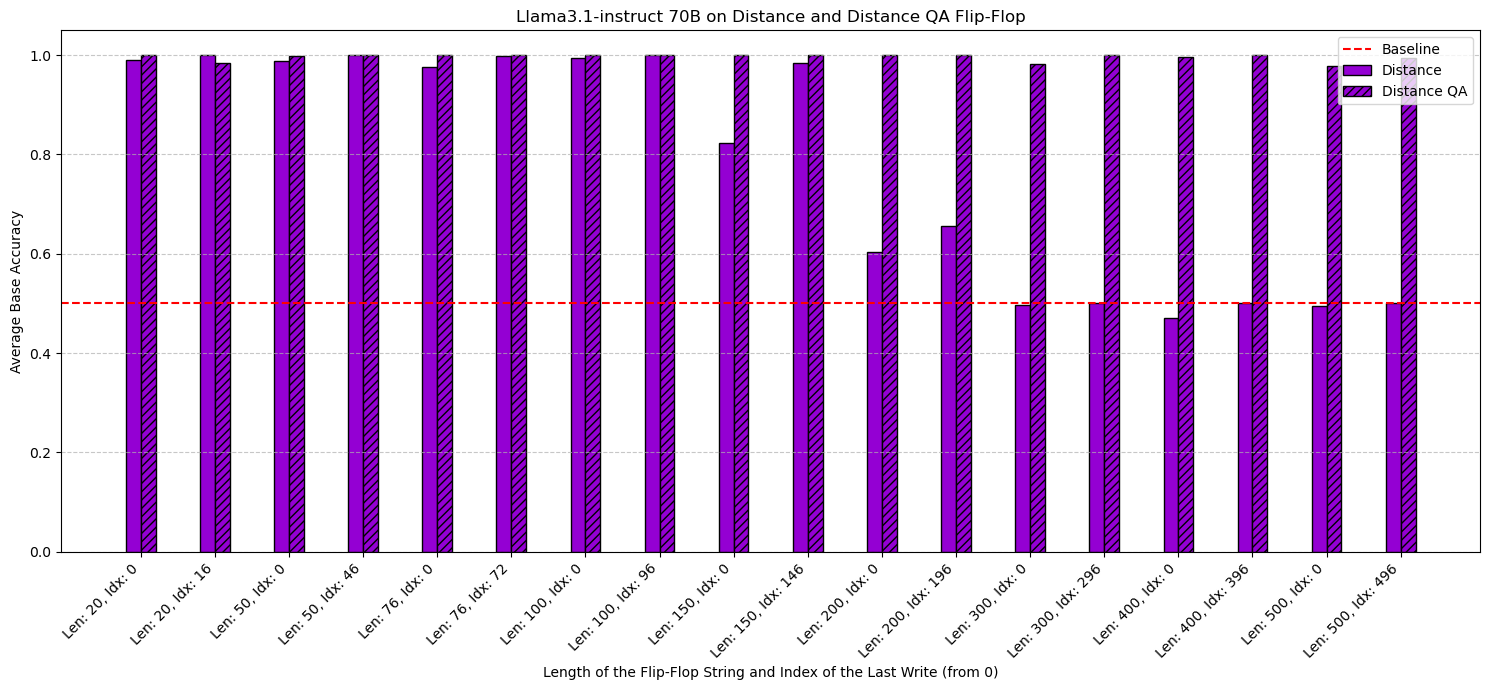

In [159]:
models = {
    "Distance": ["llama3.1_70B-instruct/distance/s1", 
                          "llama3.1_70B-instruct/distance/s2", 
                          "llama3.1_70B-instruct/distance/s3", 
                          "llama3.1_70B-instruct/distance/s4", 
                          "llama3.1_70B-instruct/distance/s5"],
        "Distance QA": ["llama3.1_70B-instruct/distance-qa/s1", 
                          "llama3.1_70B-instruct/distance-qa/s2", 
                          "llama3.1_70B-instruct/distance-qa/s3", 
                          "llama3.1_70B-instruct/distance-qa/s4", 
                          "llama3.1_70B-instruct/distance-qa/s5"],
}
title = "Llama3.1-instruct 70B on Distance and Distance QA Flip-Flop"
output_path = "graphs/llama3.1-instruct_70b_across_distance_flipflop.png"
x_axis_text = "Length of the Flip-Flop String and Index of the Last Write (from 0)"
plot_per_model_distance_accuracy(models, title, output_path, base_color="darkviolet", x_axis_text=x_axis_text, fig_width=15)

 ## Llama 3.3-instruct 70B on all subtasks

Distance: Loaded 295 entries from all folders.
Distance QA: Loaded 295 entries from all folders.


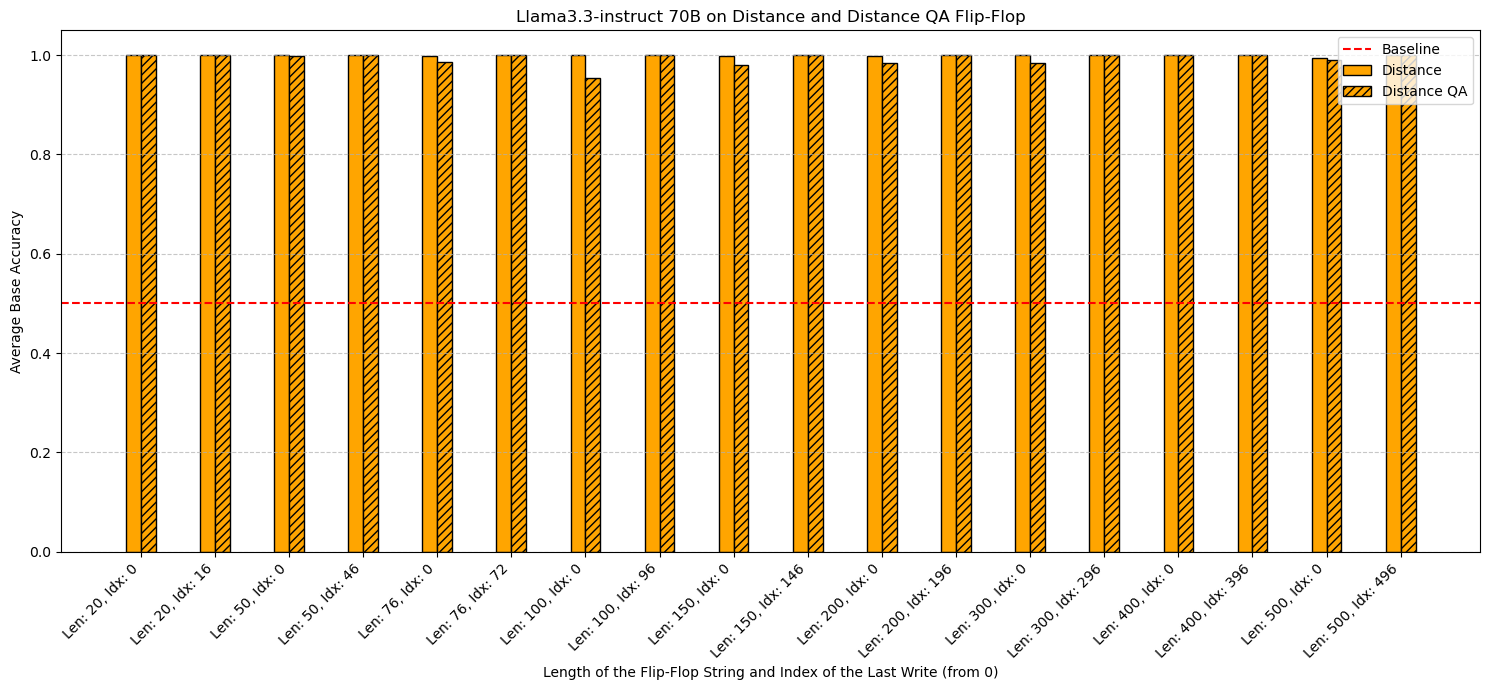

In [160]:
models = {
    "Distance": ["llama3.3_70B-instruct/distance/s1", 
                          "llama3.3_70B-instruct/distance/s2", 
                          "llama3.3_70B-instruct/distance/s3", 
                          "llama3.3_70B-instruct/distance/s4", 
                          "llama3.3_70B-instruct/distance/s5"],
        "Distance QA": ["llama3.3_70B-instruct/distance-qa/s1", 
                          "llama3.3_70B-instruct/distance-qa/s2", 
                          "llama3.3_70B-instruct/distance-qa/s3", 
                          "llama3.3_70B-instruct/distance-qa/s4", 
                          "llama3.3_70B-instruct/distance-qa/s5"],
}
title = "Llama3.3-instruct 70B on Distance and Distance QA Flip-Flop"
output_path = "graphs/llama3.3-instruct_70b_across_distance_flipflop.png"
x_axis_text = "Length of the Flip-Flop String and Index of the Last Write (from 0)"
plot_per_model_distance_accuracy(models, title, output_path, base_color="orange",x_axis_text=x_axis_text, fig_width=15)

 ## LLama 3.1-instruct 8B on all subtasks

Distance: Loaded 295 entries from all folders.
Distance QA: Loaded 295 entries from all folders.


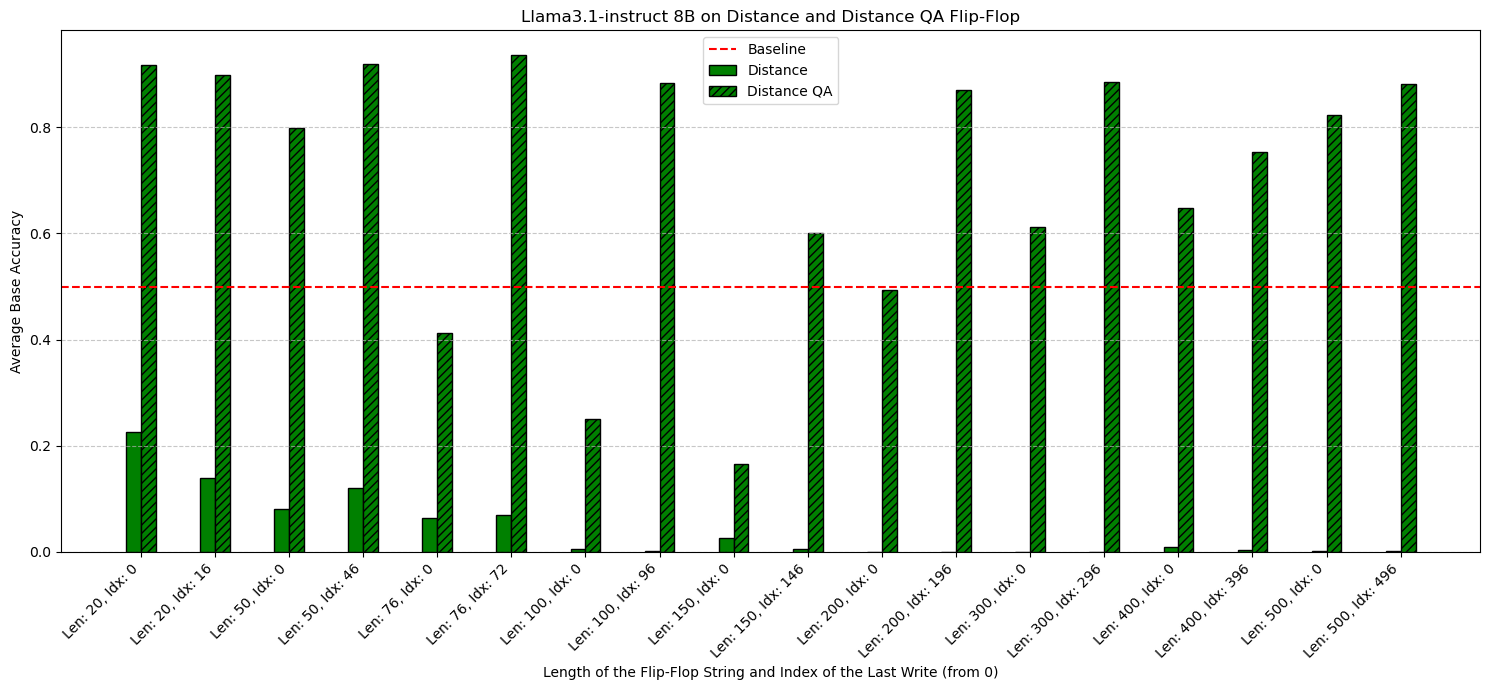

In [161]:
models = {
    "Distance": ["llama3.1_8B-instruct/distance/s1", 
                          "llama3.1_8B-instruct/distance/s2", 
                          "llama3.1_8B-instruct/distance/s3", 
                          "llama3.1_8B-instruct/distance/s4", 
                          "llama3.1_8B-instruct/distance/s5"],
        "Distance QA": ["llama3.1_8B-instruct/distance-qa/s1", 
                          "llama3.1_8B-instruct/distance-qa/s2", 
                          "llama3.1_8B-instruct/distance-qa/s3", 
                          "llama3.1_8B-instruct/distance-qa/s4", 
                          "llama3.1_8B-instruct/distance-qa/s5"],
}
title = "Llama3.1-instruct 8B on Distance and Distance QA Flip-Flop"
output_path = "graphs/llama3.1-instruct_8b_across_distance_flipflop.png"
x_axis_text = "Length of the Flip-Flop String and Index of the Last Write (from 0)"
plot_per_model_distance_accuracy(models, title, output_path, base_color="green", x_axis_text=x_axis_text, fig_width=15)

 ## Llama 3.1 8B on all subtasks

Distance: Loaded 295 entries from all folders.
Distance QA: Loaded 295 entries from all folders.


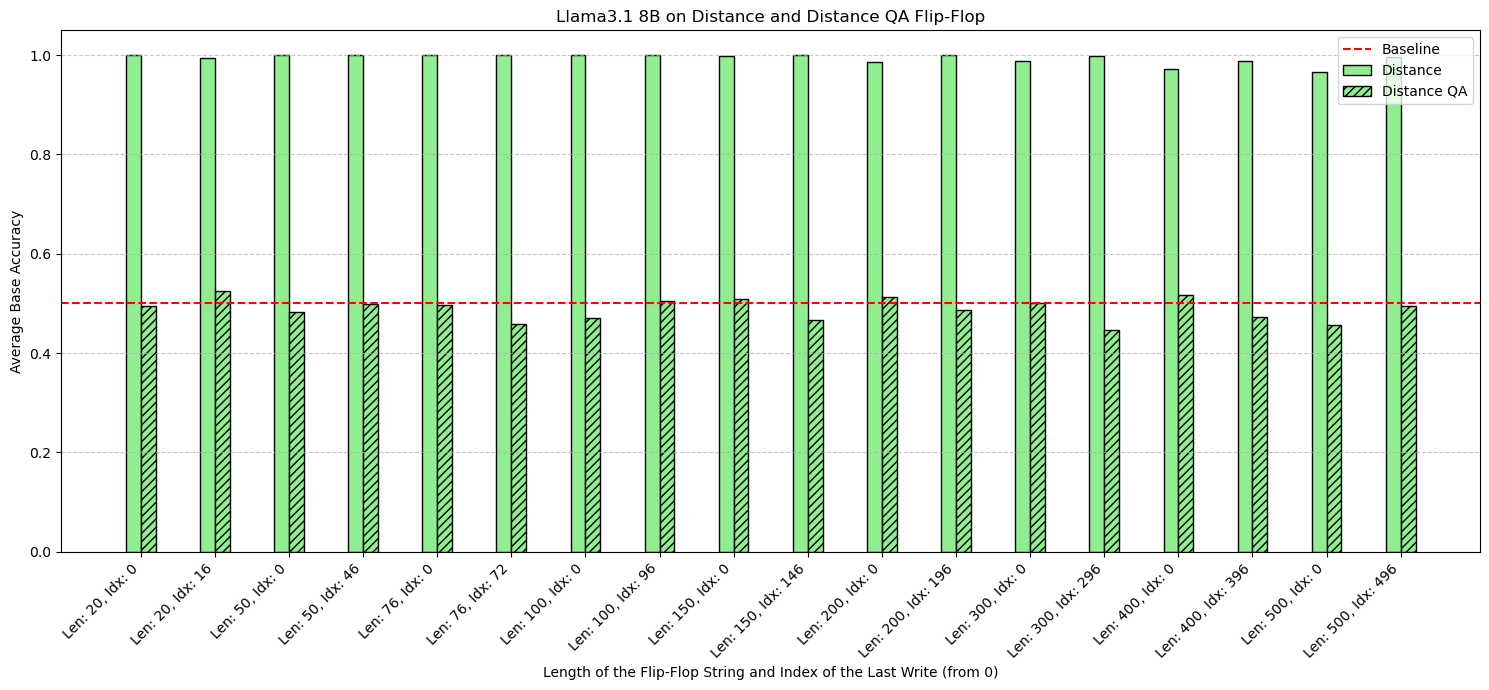

In [162]:
models = {
    "Distance": ["llama3.1_8B/distance/s1", 
                          "llama3.1_8B/distance/s2", 
                          "llama3.1_8B/distance/s3", 
                          "llama3.1_8B/distance/s4", 
                          "llama3.1_8B/distance/s5"],
        "Distance QA": ["llama3.1_8B/distance-qa/s1", 
                          "llama3.1_8B/distance-qa/s2", 
                          "llama3.1_8B/distance-qa/s3", 
                          "llama3.1_8B/distance-qa/s4", 
                          "llama3.1_8B/distance-qa/s5"],
}
title = "Llama3.1 8B on Distance and Distance QA Flip-Flop"
output_path = "graphs/llama3.1_8b_across_distance_flipflop.png"
x_axis_text = "Length of the Flip-Flop String and Index of the Last Write (from 0)"
plot_per_model_distance_accuracy(models, title, output_path, base_color="lightgreen", x_axis_text=x_axis_text, fig_width=15)

## OLMo 7B on all subtasks

Distance: Loaded 295 entries from all folders.
Distance QA: Loaded 295 entries from all folders.


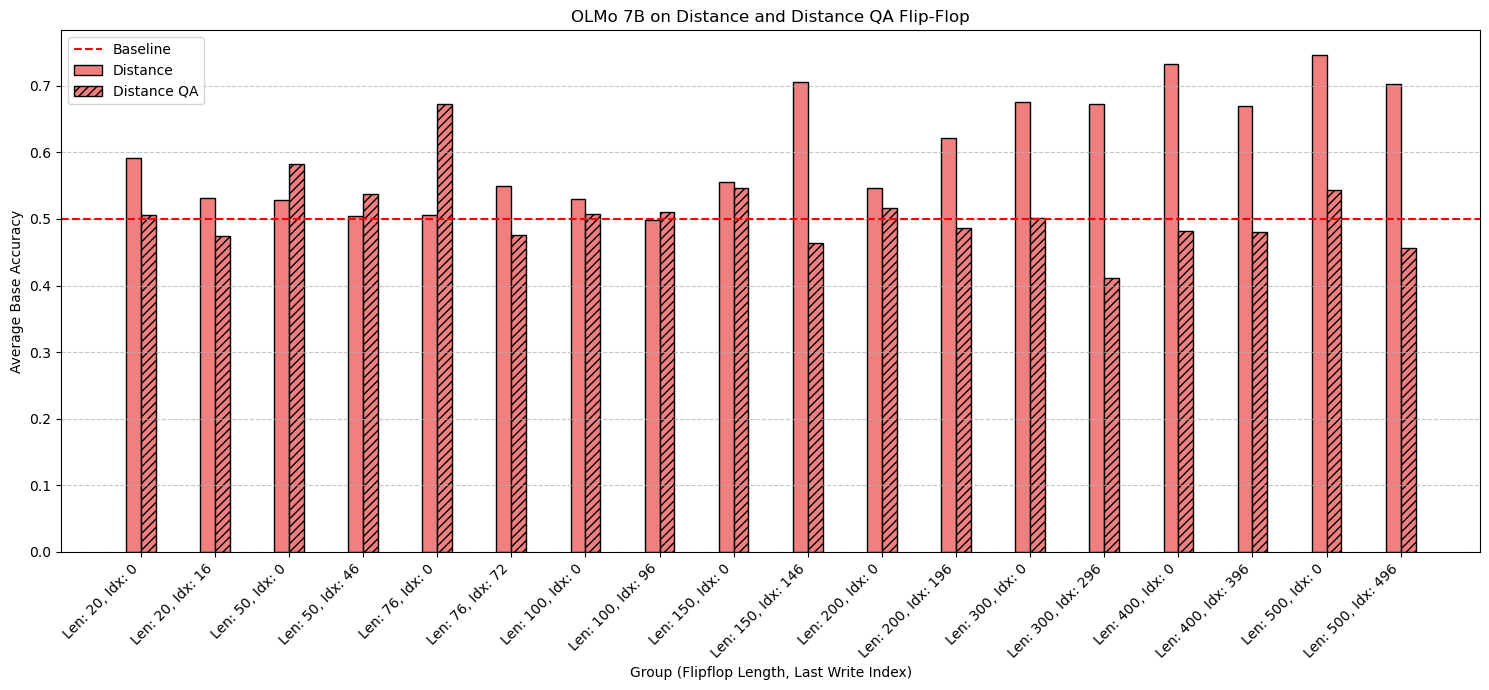

In [163]:
models = {
    "Distance": ["OLMo_7B/distance/s1", 
                          "OLMo_7B/distance/s2", 
                          "OLMo_7B/distance/s3", 
                          "OLMo_7B/distance/s4", 
                          "OLMo_7B/distance/s5"],
    "Distance QA": ["OLMo_7B/distance-qa/s1", 
                          "OLMo_7B/distance-qa/s2", 
                          "OLMo_7B/distance-qa/s3", 
                          "OLMo_7B/distance-qa/s4", 
                          "OLMo_7B/distance-qa/s5"],
}
title = "OLMo 7B on Distance and Distance QA Flip-Flop"
output_path = "graphs/olmo_7b_across_distance_flipflop.png"
x_axis_text = "Length of the Flip-Flop String and Index of the Last Write (from 0)"
plot_per_model_distance_accuracy(models, title, output_path, base_color="lightcoral", fig_width=15)

## OLMo-instruct 7b on all subtasks

Distance: Loaded 590 entries from all folders.
Distance QA: Loaded 295 entries from all folders.


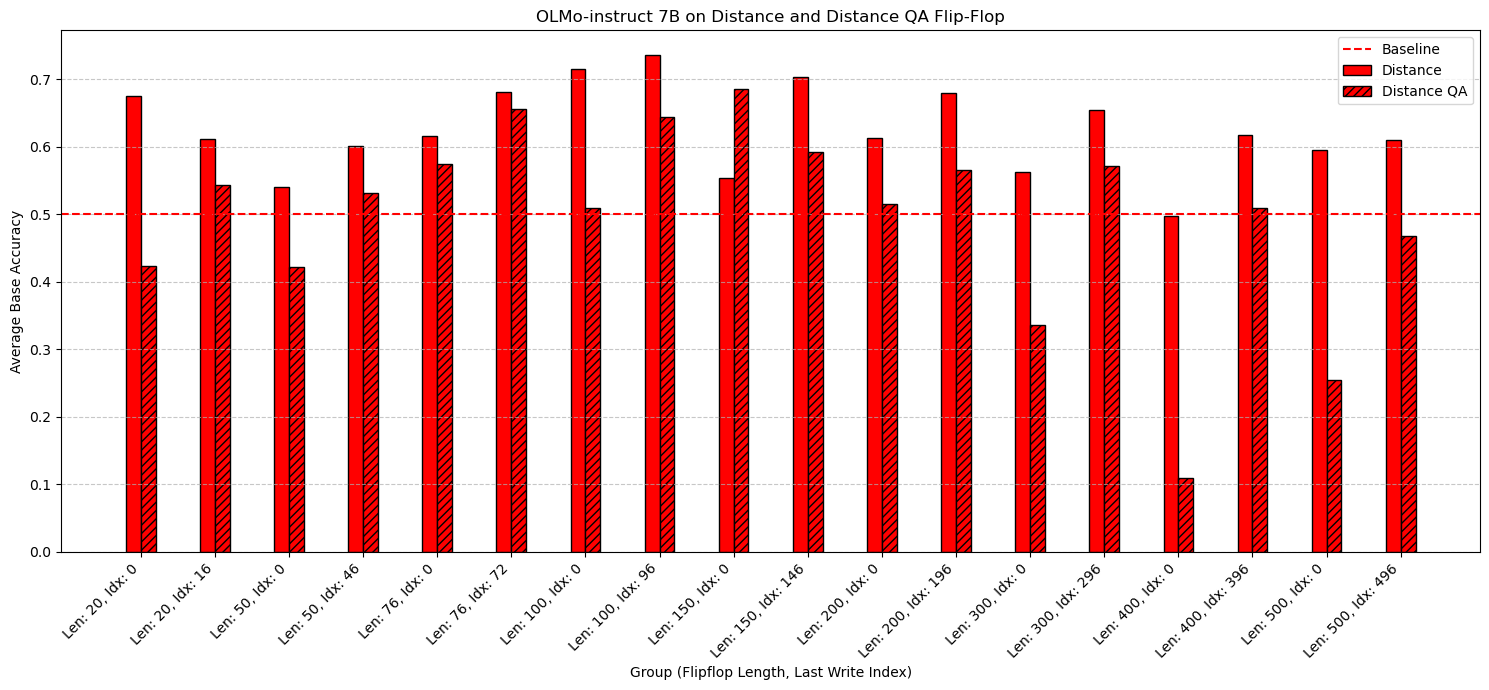

In [164]:
models = {
    "Distance": ["OLMo_7B-instruct/distance/s1", 
                          "OLMo_7B-instruct/distance/s2", 
                          "OLMo_7B-instruct/distance/s3", 
                          "OLMo_7B-instruct/distance/s4", 
                          "OLMo_7B-instruct/distance/s5"],
    "Distance QA": ["OLMo_7B-instruct/distance-qa/s1", 
                          "OLMo_7B-instruct/distance-qa/s2", 
                          "OLMo_7B-instruct/distance-qa/s3", 
                          "OLMo_7B-instruct/distance-qa/s4", 
                          "OLMo_7B-instruct/distance-qa/s5"],
}
title = "OLMo-instruct 7B on Distance and Distance QA Flip-Flop"
output_path = "graphs/olmo-instruct_7b_across_distance_flipflop.png"
x_axis_text = "Length of the Flip-Flop String and Index of the Last Write (from 0)"
plot_per_model_distance_accuracy(models, title, output_path, base_color="red", fig_width=15)

## OLMo2 7B on all subtasks

Distance: Loaded 295 entries from all folders.
Distance QA: Loaded 295 entries from all folders.


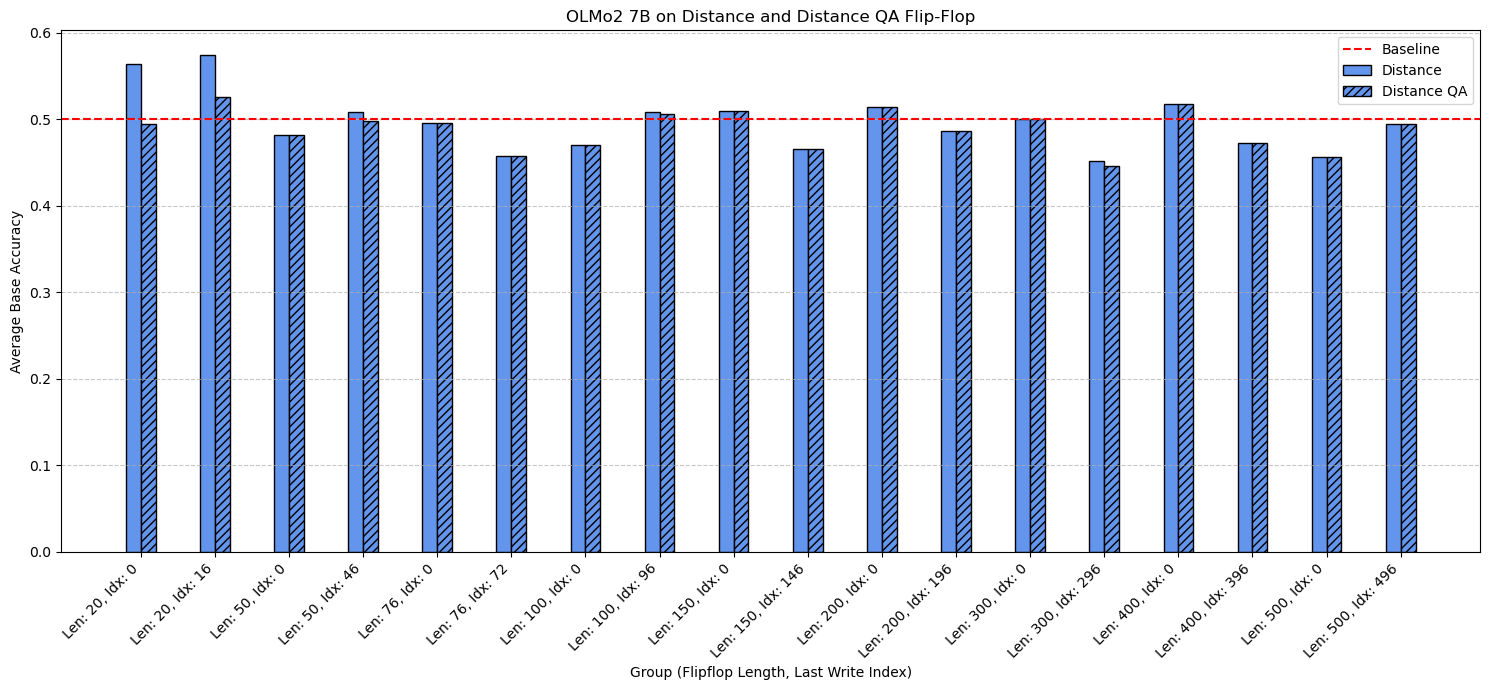

In [165]:
models = {
    "Distance": ["OLMo2_7B/distance/s1", 
                          "OLMo2_7B/distance/s2", 
                          "OLMo2_7B/distance/s3", 
                          "OLMo2_7B/distance/s4", 
                          "OLMo2_7B/distance/s5"],
    "Distance QA": ["OLMo2_7B/distance-qa/s1", 
                          "OLMo2_7B/distance-qa/s2", 
                          "OLMo2_7B/distance-qa/s3", 
                          "OLMo2_7B/distance-qa/s4", 
                          "OLMo2_7B/distance-qa/s5"],
}
title = "OLMo2 7B on Distance and Distance QA Flip-Flop"
output_path = "graphs/olmo2_7b_across_distance_flipflop.png"
x_axis_text = "Length of the Flip-Flop String and Index of the Last Write (from 0)"
plot_per_model_distance_accuracy(models, title, output_path, base_color="cornflowerblue", fig_width=15)

## OLMo2-instruct 7B on all subtasks

Distance: Loaded 295 entries from all folders.
Distance QA: Loaded 295 entries from all folders.


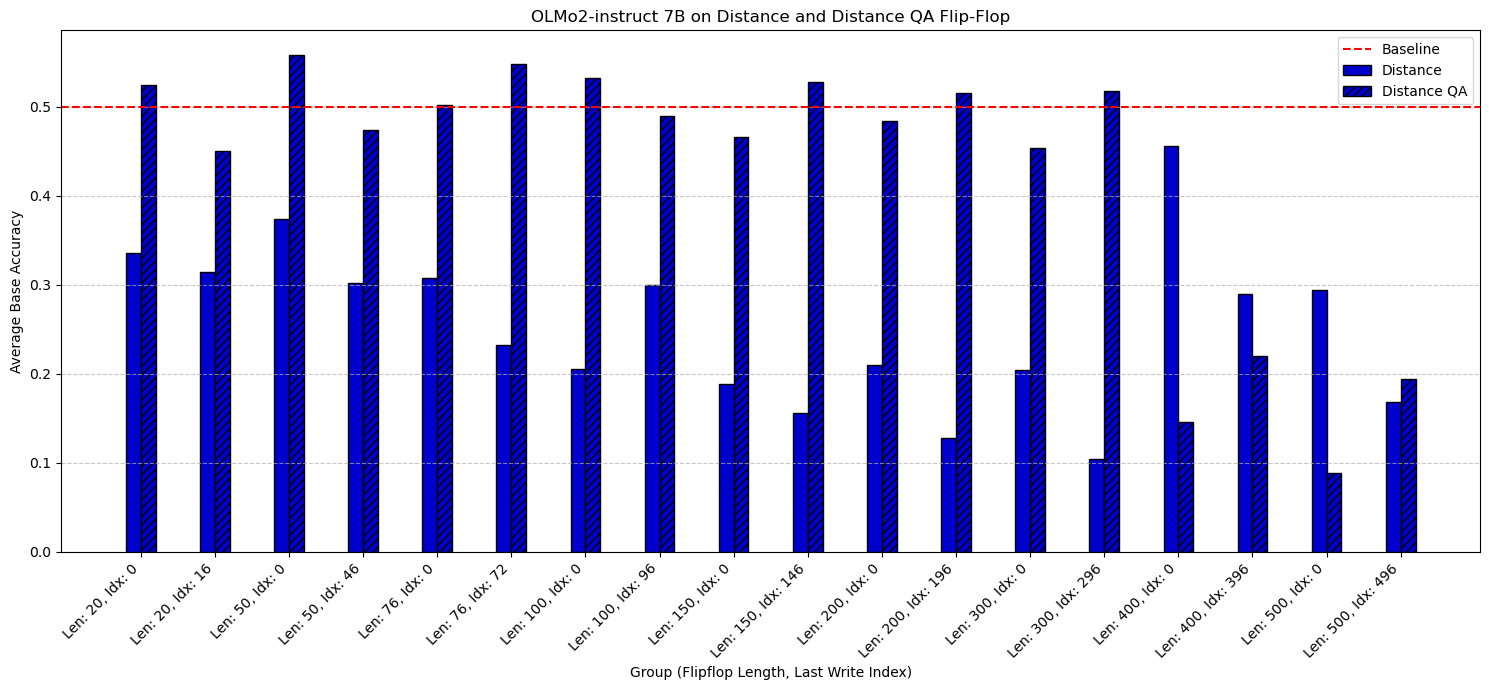

In [166]:
models = {
    "Distance": ["OLMo2_7B-instruct/distance/s1", 
                          "OLMo2_7B-instruct/distance/s2", 
                          "OLMo2_7B-instruct/distance/s3", 
                          "OLMo2_7B-instruct/distance/s4", 
                          "OLMo2_7B-instruct/distance/s5"],
    "Distance QA": ["OLMo2_7B-instruct/distance-qa/s1", 
                          "OLMo2_7B-instruct/distance-qa/s2", 
                          "OLMo2_7B-instruct/distance-qa/s3", 
                          "OLMo2_7B-instruct/distance-qa/s4", 
                          "OLMo2_7B-instruct/distance-qa/s5"],
}

title = "OLMo2-instruct 7B on Distance and Distance QA Flip-Flop"
output_path = "graphs/olmo2-instruct_7b_across_distance_flipflop.png"
x_axis_text = "Length of the Flip-Flop String and Index of the Last Write (from 0)"
plot_per_model_distance_accuracy(models, title, output_path, base_color="mediumblue", fig_width=15)

## OLMo2 13B on all subtasks

Distance: Loaded 295 entries from all folders.
Distance QA: Loaded 295 entries from all folders.


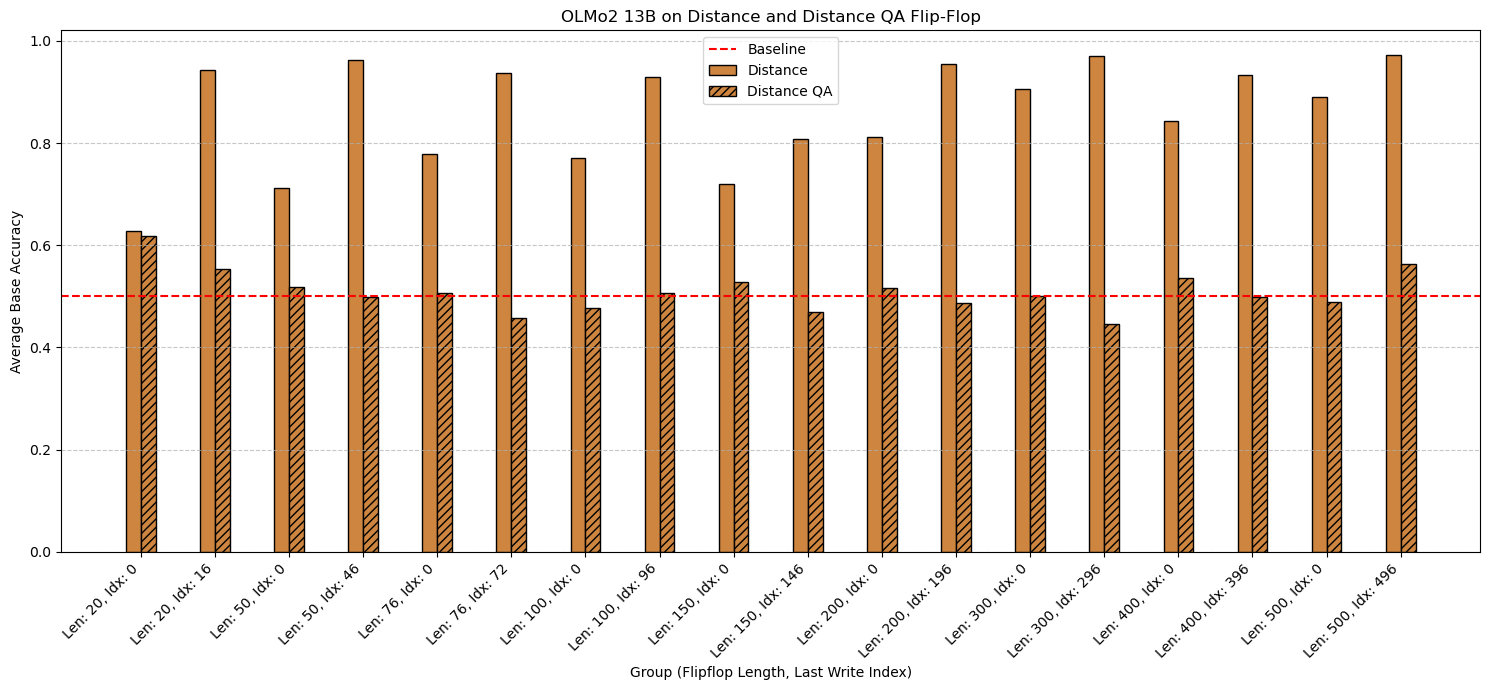

In [167]:
models = {
    "Distance": ["OLMo2_13B/distance/s1", 
                          "OLMo2_13B/distance/s2", 
                          "OLMo2_13B/distance/s3", 
                          "OLMo2_13B/distance/s4", 
                          "OLMo2_13B/distance/s5"],
    "Distance QA": ["OLMo2_13B/distance-qa/s1", 
                          "OLMo2_13B/distance-qa/s2", 
                          "OLMo2_13B/distance-qa/s3", 
                          "OLMo2_13B/distance-qa/s4", 
                          "OLMo2_13B/distance-qa/s5"],
}
title = "OLMo2 13B on Distance and Distance QA Flip-Flop"
output_path = "graphs/olmo2_13b_across_distance_flipflop.png"
x_axis_text = "Length of the Flip-Flop String and Index of the Last Write (from 0)"
plot_per_model_distance_accuracy(models, title, output_path, base_color="peru", fig_width=15)

## OLMo2-instruct 13B on all subtasks

Distance: Loaded 295 entries from all folders.
Distance QA: Loaded 295 entries from all folders.


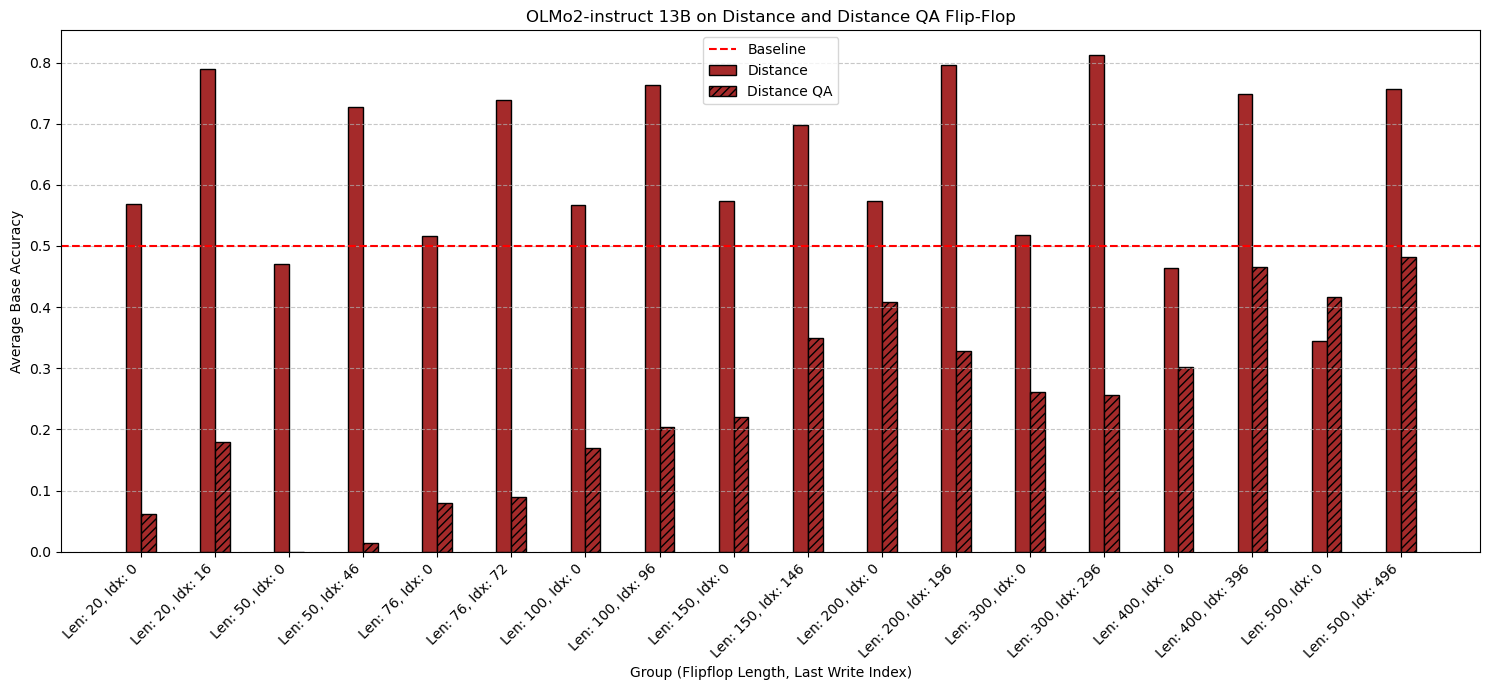

In [168]:
models = {
    "Distance": ["OLMo2_13B-instruct/distance/s1", 
                          "OLMo2_13B-instruct/distance/s2", 
                          "OLMo2_13B-instruct/distance/s3", 
                          "OLMo2_13B-instruct/distance/s4", 
                          "OLMo2_13B-instruct/distance/s5"],
    "Distance QA": ["OLMo2_13B-instruct/distance-qa/s1", 
                          "OLMo2_13B-instruct/distance-qa/s2", 
                          "OLMo2_13B-instruct/distance-qa/s3", 
                          "OLMo2_13B-instruct/distance-qa/s4", 
                          "OLMo2_13B-instruct/distance-qa/s5"],
}
title = "OLMo2-instruct 13B on Distance and Distance QA Flip-Flop"
output_path = "graphs/olmo2-instruct_13b_across_distance_flipflop.png"
x_axis_text = "Length of the Flip-Flop String and Index of the Last Write (from 0)"
plot_per_model_distance_accuracy(models, title, output_path, base_color="brown", fig_width=15)

## All Llamas together

llama3.1_70B: Loaded 295 entries from all folders.
llama3.1_70B-instruct: Loaded 590 entries from all folders.
llama3.3_70B-instruct: Loaded 295 entries from all folders.
llama3.1_8B: Loaded 295 entries from all folders.
llama3.1_8B-instruct: Loaded 295 entries from all folders.


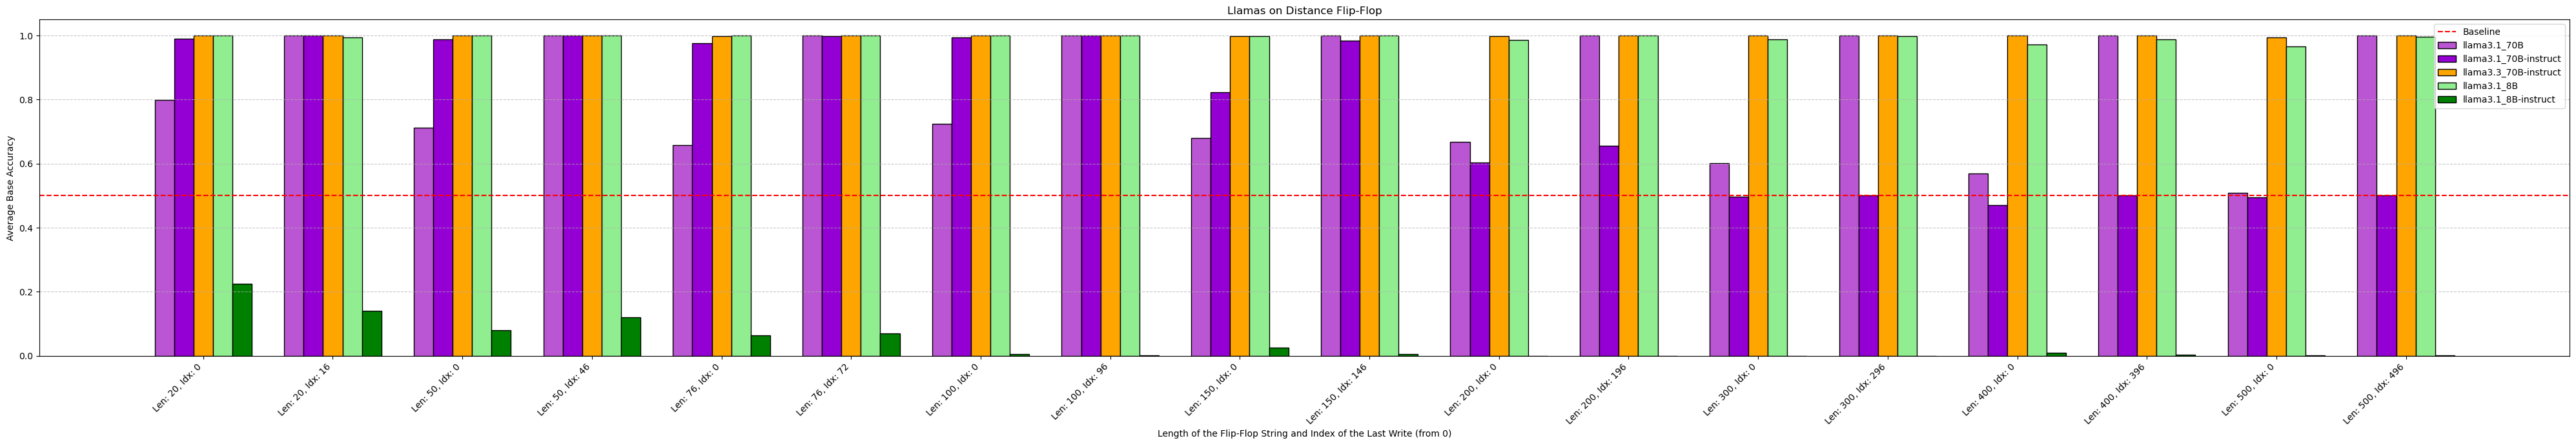

In [169]:
# DISTANCE 
models = {
    "llama3.1_70B": ["llama3.1_70B/distance/s1", 
                          "llama3.1_70B/distance/s2", 
                          "llama3.1_70B/distance/s3", 
                          "llama3.1_70B/distance/s4", 
                          "llama3.1_70B/distance/s5"],
    "llama3.1_70B-instruct": ["llama3.1_70B-instruct/distance/s1", 
                 "llama3.1_70B-instruct/distance/s2", 
                 "llama3.1_70B-instruct/distance/s3", 
                 "llama3.1_70B-instruct/distance/s4", 
                 "llama3.1_70B-instruct/distance/s5"],
    "llama3.3_70B-instruct": ["llama3.3_70B-instruct/distance/s1", 
                 "llama3.3_70B-instruct/distance/s2", 
                 "llama3.3_70B-instruct/distance/s3", 
                 "llama3.3_70B-instruct/distance/s4", 
                 "llama3.3_70B-instruct/distance/s5"],
        "llama3.1_8B": ["llama3.1_8B/distance/s1", 
                 "llama3.1_8B/distance/s2", 
                 "llama3.1_8B/distance/s3", 
                 "llama3.1_8B/distance/s4", 
                 "llama3.1_8B/distance/s5"],
    "llama3.1_8B-instruct": ["llama3.1_8B-instruct/distance/s1", 
                          "llama3.1_8B-instruct/distance/s2", 
                          "llama3.1_8B-instruct/distance/s3", 
                          "llama3.1_8B-instruct/distance/s4", 
                          "llama3.1_8B-instruct/distance/s5"]
}
title = "Llamas on Distance Flip-Flop"
output_path = "graphs/llamas_across_distance_flipflop.png"
x_axis_text = "Length of the Flip-Flop String and Index of the Last Write (from 0)"
plot_distance_accuracy(models, title, output_path, fig_width=40, bar_width=0.15, x_axis_text=x_axis_text)

llama3.1_70B: Loaded 353 entries from all folders.
llama3.1_70B-instruct: Loaded 295 entries from all folders.
llama3.3_70B-instruct: Loaded 295 entries from all folders.
llama3.1_8B: Loaded 295 entries from all folders.
llama3.1_8B-instruct: Loaded 295 entries from all folders.


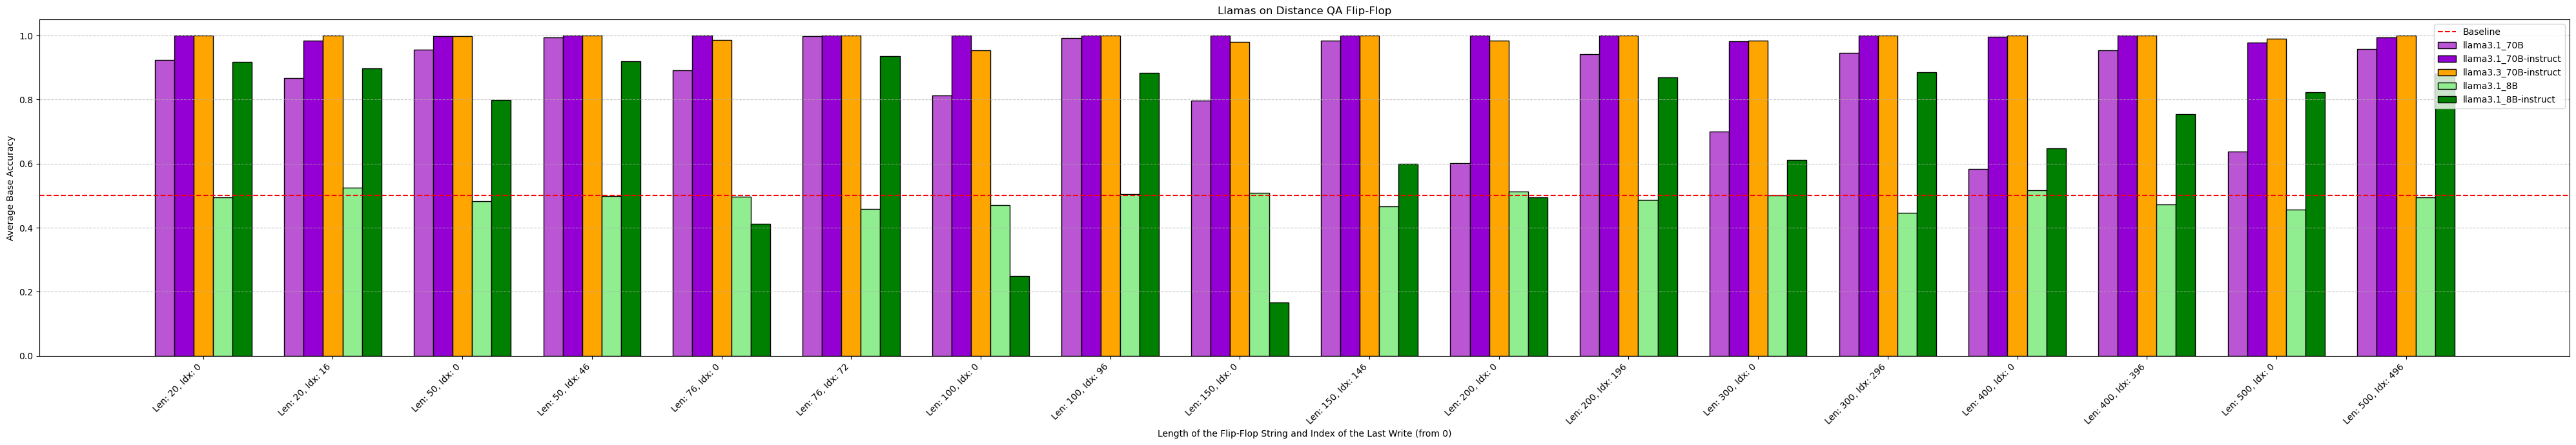

In [170]:
# DISTANCE QA
models = {
    "llama3.1_70B": ["llama3.1_70B/distance-qa/s1", 
                          "llama3.1_70B/distance-qa/s2", 
                          "llama3.1_70B/distance-qa/s2", 
                          "llama3.1_70B/distance-qa/s3", 
                          "llama3.1_70B/distance-qa/s4", 
                          "llama3.1_70B/distance-qa/s5"],
    "llama3.1_70B-instruct": ["llama3.1_70B-instruct/distance-qa/s1", 
                 "llama3.1_70B-instruct/distance-qa/s2", 
                 "llama3.1_70B-instruct/distance-qa/s3", 
                 "llama3.1_70B-instruct/distance-qa/s4", 
                 "llama3.1_70B-instruct/distance-qa/s5"],
    "llama3.3_70B-instruct": ["llama3.3_70B-instruct/distance-qa/s1", 
                 "llama3.3_70B-instruct/distance-qa/s2", 
                 "llama3.3_70B-instruct/distance-qa/s3", 
                 "llama3.3_70B-instruct/distance-qa/s4", 
                 "llama3.3_70B-instruct/distance-qa/s5"],
        "llama3.1_8B": ["llama3.1_8B/distance-qa/s1", 
                 "llama3.1_8B/distance-qa/s2", 
                 "llama3.1_8B/distance-qa/s3", 
                 "llama3.1_8B/distance-qa/s4", 
                 "llama3.1_8B/distance-qa/s5"],
    "llama3.1_8B-instruct": ["llama3.1_8B-instruct/distance-qa/s1", 
                          "llama3.1_8B-instruct/distance-qa/s2", 
                          "llama3.1_8B-instruct/distance-qa/s3", 
                          "llama3.1_8B-instruct/distance-qa/s4", 
                          "llama3.1_8B-instruct/distance-qa/s5"]
}
title = "Llamas on Distance QA Flip-Flop"
output_path = "graphs/llamas_across_distance_qa_flipflop.png"
x_axis_text = "Length of the Flip-Flop String and Index of the Last Write (from 0)"
plot_distance_accuracy(models, title, output_path, fig_width=40, bar_width=0.15, x_axis_text=x_axis_text)

## All OLMos together

OLMo_7B: Loaded 295 entries from all folders.
OLMo_7B-instruct: Loaded 590 entries from all folders.
OLMo2_7B: Loaded 295 entries from all folders.
OLMo2_13B: Loaded 295 entries from all folders.
OLMo2_7B-instruct: Loaded 295 entries from all folders.
OLMo2_13B-instruct: Loaded 295 entries from all folders.


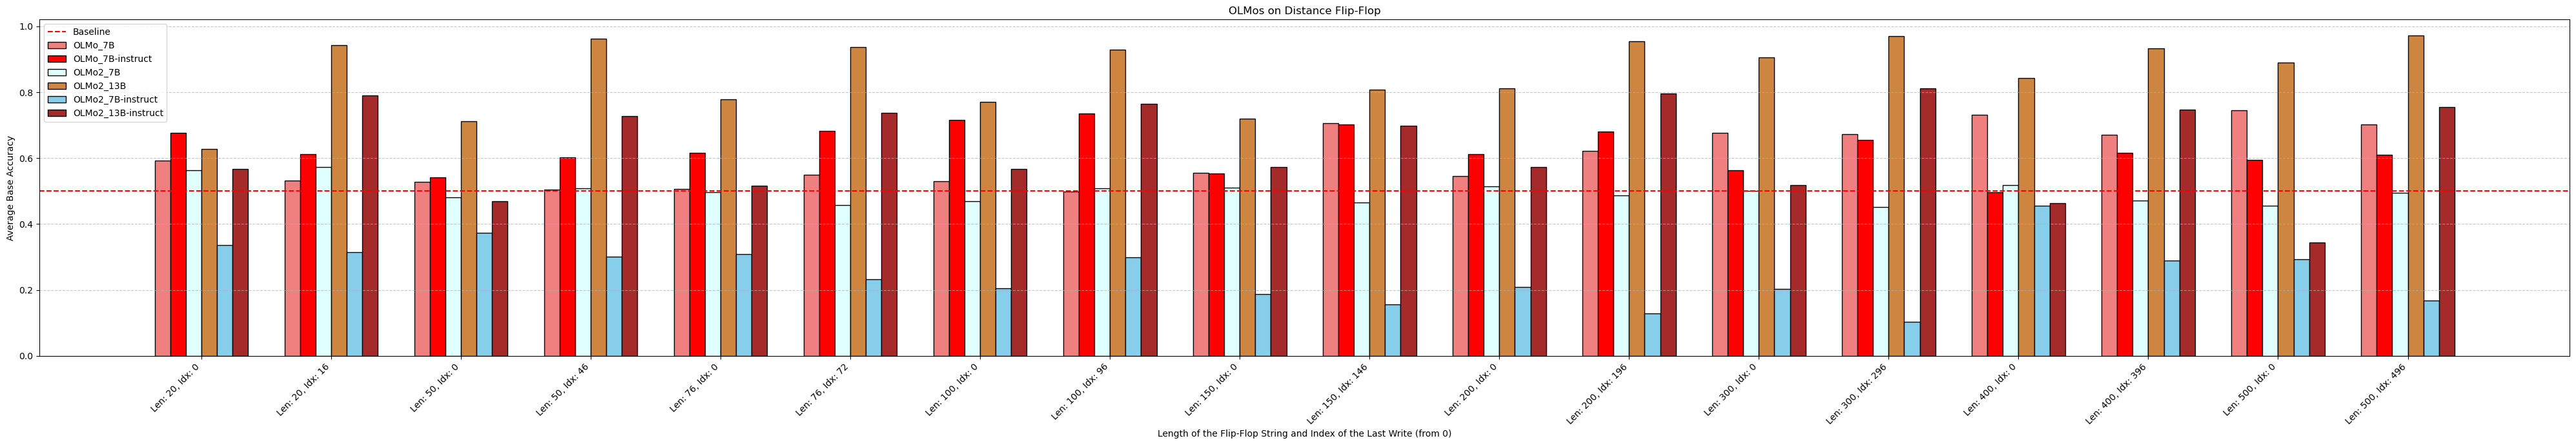

In [171]:
# DISTANCE
models = {
    "OLMo_7B": ["OLMo_7B/distance/s1", 
                          "OLMo_7B/distance/s2", 
                          "OLMo_7B/distance/s3", 
                          "OLMo_7B/distance/s4", 
                          "OLMo_7B/distance/s5"],
    "OLMo_7B-instruct": ["OLMo_7B-instruct/distance/s1", 
                 "OLMo_7B-instruct/distance/s2", 
                 "OLMo_7B-instruct/distance/s3", 
                 "OLMo_7B-instruct/distance/s4", 
                 "OLMo_7B-instruct/distance/s5"],
        "OLMo2_7B": ["OLMo2_7B/distance/s1", 
            "OLMo2_7B/distance/s2",
            "OLMo2_7B/distance/s3",
            "OLMo2_7B/distance/s4",
            "OLMo2_7B/distance/s5"],
    "OLMo2_13B": ["OLMo2_13B/distance/s1", 
            "OLMo2_13B/distance/s2",
            "OLMo2_13B/distance/s3",
            "OLMo2_13B/distance/s4",
            "OLMo2_13B/distance/s5"],
    "OLMo2_7B-instruct": ["OLMo2_7B-instruct/distance/s1", 
            "OLMo2_7B-instruct/distance/s2",
            "OLMo2_7B-instruct/distance/s3",
            "OLMo2_7B-instruct/distance/s4",
            "OLMo2_7B-instruct/distance/s5"],
    "OLMo2_13B-instruct": ["OLMo2_13B-instruct/distance/s1", 
            "OLMo2_13B-instruct/distance/s2",
            "OLMo2_13B-instruct/distance/s3",
            "OLMo2_13B-instruct/distance/s4",
            "OLMo2_13B-instruct/distance/s5"]
}
title = "OLMos on Distance Flip-Flop"
output_path = "graphs/olmos_across_distance_flipflop.png"
x_axis_text = "Length of the Flip-Flop String and Index of the Last Write (from 0)"
plot_distance_accuracy(models, title, output_path, fig_width=40, x_axis_text=x_axis_text, bar_width=0.12)

OLMo_7B: Loaded 295 entries from all folders.
OLMo_7B-instruct: Loaded 295 entries from all folders.
OLMo2_7B: Loaded 295 entries from all folders.
OLMo2_13B: Loaded 295 entries from all folders.
OLMo2_7B-instruct: Loaded 295 entries from all folders.
OLMo2_13B-instruct: Loaded 295 entries from all folders.


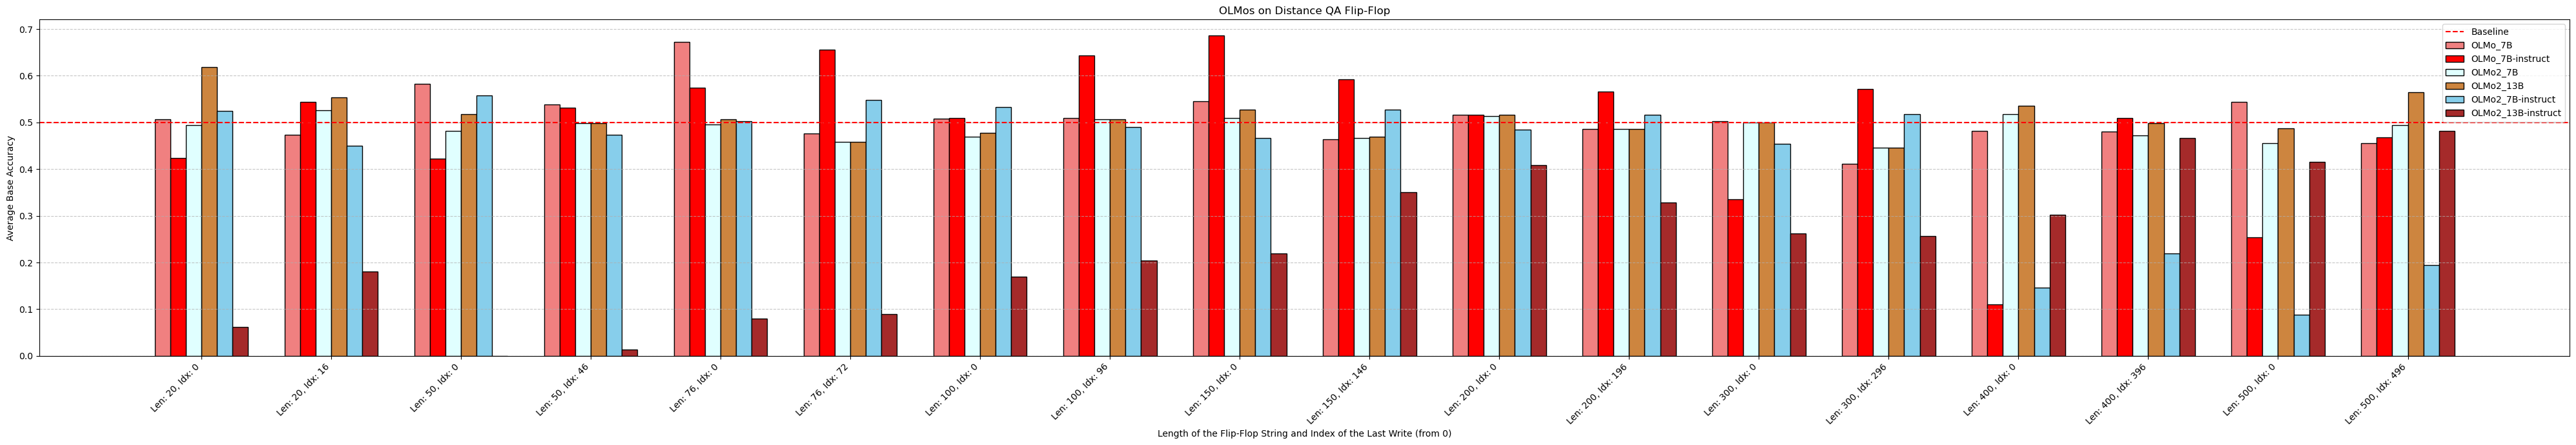

In [172]:
# DISTANCE QA
models = {
    "OLMo_7B": ["OLMo_7B/distance-qa/s1", 
                          "OLMo_7B/distance-qa/s2", 
                          "OLMo_7B/distance-qa/s3", 
                          "OLMo_7B/distance-qa/s4", 
                          "OLMo_7B/distance-qa/s5"],
    "OLMo_7B-instruct": ["OLMo_7B-instruct/distance-qa/s1", 
                 "OLMo_7B-instruct/distance-qa/s2", 
                 "OLMo_7B-instruct/distance-qa/s3", 
                 "OLMo_7B-instruct/distance-qa/s4", 
                 "OLMo_7B-instruct/distance-qa/s5"],
        "OLMo2_7B": ["OLMo2_7B/distance-qa/s1", 
            "OLMo2_7B/distance-qa/s2",
            "OLMo2_7B/distance-qa/s3",
            "OLMo2_7B/distance-qa/s4",
            "OLMo2_7B/distance-qa/s5"],
    "OLMo2_13B": ["OLMo2_13B/distance-qa/s1", 
            "OLMo2_13B/distance-qa/s2",
            "OLMo2_13B/distance-qa/s3",
            "OLMo2_13B/distance-qa/s4",
            "OLMo2_13B/distance-qa/s5"],
    "OLMo2_7B-instruct": ["OLMo2_7B-instruct/distance-qa/s1", 
            "OLMo2_7B-instruct/distance-qa/s2",
            "OLMo2_7B-instruct/distance-qa/s3",
            "OLMo2_7B-instruct/distance-qa/s4",
            "OLMo2_7B-instruct/distance-qa/s5"],
    "OLMo2_13B-instruct": ["OLMo2_13B-instruct/distance-qa/s1", 
            "OLMo2_13B-instruct/distance-qa/s2",
            "OLMo2_13B-instruct/distance-qa/s3",
            "OLMo2_13B-instruct/distance-qa/s4",
            "OLMo2_13B-instruct/distance-qa/s5"]
}
title = "OLMos on Distance QA Flip-Flop"
output_path = "graphs/olmos_across_distance_qa_flipflop.png"
x_axis_text = "Length of the Flip-Flop String and Index of the Last Write (from 0)"
plot_distance_accuracy(models, title, output_path, fig_width=40, x_axis_text=x_axis_text, bar_width=0.12)